# Predictive Regression
### Riya Sheth

riyasheth@uchicago.edu

### Index
1. Introduction
2. Imports
3. Procuring Data
4. Data Analysis
5. Description of Models
6. CAPM - Model
7. CAPM - Analysis
8. Contemporaneous Model for returns for CDS Spread
9. Contemporaneous Model for returns for CDS Spread- Analysis
10. Creation of the Hedge Portfolio Return
11. Calculation of Residual Return
12. Calculation of Residual Equity Return
13. Residual Return and Residual Equity Return Model (BoxCar)
14. Residual Return and Residual Equity Return Model- Analysis (BoxCar)
15. Residual Return and Residual Equity Return Model (Exponentially Decaying)
16. Residual Return and Residual Equity Return Model - Analysis (Exponentially Decaying)
17. Compare performance of predictive regressions in exponentially decaying (i.e. discounted) versus boxcar forms.
18. Historical Events and their Impact
19. Tails and Other statistics
20. Creation of a trading strategy
21. ARMA Regression
22. Train/test split regression
23. Conclusion

### 1. Introduction 
Objective of the Project: Using boxcar and discounted least squares regression for predicting the hedged CDS spread returns. We compare and contrast the two regression techniques.


### 2. Imports

In [264]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import statistics
import statsmodels.api as sm
quandl.ApiConfig.api_key= "dSEK8-iUMxdiDUyrcPdc"
import warnings
from datetime import timedelta
from sklearn import preprocessing
from datetime import datetime
import random
from plotnine import *
import statsmodels.regression.linear_model as linreg
import patchworklib as pw
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.graphics.gofplots as smg
import statsmodels.stats.outliers_influence as oi
warnings.filterwarnings('ignore')
from scipy.stats import ttest_1samp

### 3. Procuring Data

#### 5 year CDS rates 

CDS- A credit default swap is a contract in which the buyer of the swap makes payments to the seller of the swap, in exchange for a guarantee that the seller will make a payment if the underlying company or entity defaults on its debt obligations.

5 year- CDS rate has a tenure because it represents the cost of insuring against the default risk of a particular company or entity over a specific period of time.

Rates/spread- CDS par spread refers to the fixed coupon rate that would make the upfront price of a CDS equal to its expected value. In other words, it is the spread over a benchmark interest rate that would make the present value of the CDS payments equal to the upfront cost of buying the protection.

In [50]:
#reading the CDS data
cds = pd.read_csv('Liq5YCDS.delim', delimiter='\t')
cds = cds.drop(cds.columns[0], axis=1)
cds['date'] = pd.to_datetime(cds['date'])
cds= cds.set_index('date')
cds.head()

ticker tenor  parspread   upfront  runningcoupon  cdsrealrecovery  \
date                                                                           
2018-01-01     BA    5Y   0.001793 -0.038914           0.01             0.40   
2018-01-01      C    5Y   0.004113 -0.027708           0.01             0.40   
2018-01-01     DD    5Y   0.002476 -0.035641           0.01             0.40   
2018-01-01      F    5Y   0.008805 -0.192592           0.05             0.39   
2018-01-01     GE    5Y   0.004037 -0.028103           0.01             0.40   

            cdsassumedrecovery docclause currency    tier impliedrating  
date                                                                     
2018-01-01                 0.4      MR14      USD  SNRFOR           BBB  
2018-01-01                 0.4      MR14      USD  SNRFOR             A  
2018-01-01                 0.4      MR14      USD  SNRFOR             A  
2018-01-01                 0.4      MR14      USD  SNRFOR            BB  
2018-01-01                 0.4      MR14      USD  SNRFOR           BBB

In [3]:
start_date= cds.index[0]
end_date= cds.index[-1]

In [4]:
unique_tickers= set(cds['ticker'])
unique_tickers= list(unique_tickers)
print("Equities: ", unique_tickers)

Equities:  ['C', 'BA', 'LNC', 'JPM', 'F', 'WFC', 'XOM', 'NFLX', 'LOW', 'T', 'DD', 'MAR', 'LUV', 'XRX', 'GE']


In [5]:
#loading the corresponding adjusted close prices for the corresponding equity
adj_close_dic={}
for tick in unique_tickers:
    data= quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': start_date, 'lte': end_date }, ticker= tick)
    adj_close_dic[tick]= data

In [269]:
adj_close_dic['BA'].tail()

ticker       date    open    high      low   close     volume  dividend  \
None                                                                           
1254     BA 2018-01-08  308.66  310.86  305.750  310.15  4120544.0       0.0   
1255     BA 2018-01-05  296.77  308.89  296.720  308.84  6173196.0       0.0   
1256     BA 2018-01-04  297.94  298.42  295.470  296.67  4170929.0       0.0   
1257     BA 2018-01-03  295.94  298.50  295.470  297.80  3211195.0       0.0   
1258     BA 2018-01-02  295.75  296.99  295.396  296.84  2978918.0       0.0   

      split    adj_open    adj_high     adj_low   adj_close  adj_volume  
None                                                                     
1254    1.0  294.093326  296.189501  291.320659  295.513008   4120544.0  
1255    1.0  282.764454  294.312472  282.716814  294.264831   6173196.0  
1256    1.0  283.879238  284.336585  281.525805  282.669173   4170929.0  
1257    1.0  281.973624  284.412810  281.525805  283.745845   3211195.0  
1258    1.0  281.792591  282.974072  281.455298  282.831151   2978918.0

In [6]:
#splitting the cds dataframe into smaller dataframes after grouping by equity
cds_dic={}
for ticker in unique_tickers:
    dataframe = cds[cds['ticker'] == ticker]
    cds_dic[ticker]= dataframe

In [270]:
cds_dic['BA'].head()

ticker tenor  parspread   upfront  runningcoupon  cdsrealrecovery  \
date                                                                           
2018-01-01     BA    5Y   0.001793 -0.038914           0.01              0.4   
2018-01-02     BA    5Y   0.001768 -0.039014           0.01              0.4   
2018-01-03     BA    5Y   0.001682 -0.228787           0.05              0.4   
2018-01-04     BA    5Y   0.001659 -0.228765           0.05              0.4   
2018-01-05     BA    5Y   0.001634 -0.228609           0.05              0.4   

            cdsassumedrecovery docclause currency    tier impliedrating  
date                                                                     
2018-01-01                 0.4      MR14      USD  SNRFOR           BBB  
2018-01-02                 0.4      MR14      USD  SNRFOR           BBB  
2018-01-03                 0.4      MR14      USD  SNRFOR           BBB  
2018-01-04                 0.4      MR14      USD  SNRFOR           BBB  
2018-01-05                 0.4      MR14      USD  SNRFOR           BBB

In [51]:
#merging the cds and the adj close dataframe
etf_df_dic={}
for ticker in unique_tickers:
    d1= cds_dic[ticker]
    d1= d1.drop(d1.index[0])
    d2= adj_close_dic[ticker]
    d1= d1.reset_index(drop= True)
    d2 = d2.iloc[::-1, :]
    d2= d2.reset_index(drop= True)
    new_dataframe= pd.DataFrame()
    new_dataframe['date']= d2['date']
    new_dataframe['ticker']= d2['ticker']
    new_dataframe['parspread']= d1['parspread']
    new_dataframe['adj_close']= d2['adj_close']
    etf_df_dic[ticker]= new_dataframe

In [271]:
etf_df_dic['BA'].head()

ticker  parspread   adj_close  returns_equity  returns_cds
date                                                                 
2018-01-10     BA   0.001585  305.145884        0.075420    -0.057555
2018-01-17     BA   0.001712  334.444691        0.096016     0.079885
2018-01-24     BA   0.001762  318.894885       -0.046494     0.029635
2018-01-31     BA   0.001743  337.646122        0.058801    -0.010986
2018-02-07     BA   0.002202  331.691080       -0.017637     0.263577

In [53]:
#getting weekly to weekly wednesday returns on adj_close and cds_spreads
for ticker in unique_tickers:
    df= etf_df_dic[ticker]
    df= df.set_index('date', drop=True)
    df= df.resample('W-WED').last()
    df['returns_equity']= df['adj_close'].pct_change()
    df['returns_cds']= df['parspread'].pct_change()
    df = df.drop(df.index[0])
    etf_df_dic[ticker]= df

In [54]:
#example of a dataframe
display(etf_df_dic['BA'].head())

ticker  parspread   adj_close  returns_equity  returns_cds
date                                                                 
2018-01-10     BA   0.001585  305.145884        0.075420    -0.057555
2018-01-17     BA   0.001712  334.444691        0.096016     0.079885
2018-01-24     BA   0.001762  318.894885       -0.046494     0.029635
2018-01-31     BA   0.001743  337.646122        0.058801    -0.010986
2018-02-07     BA   0.002202  331.691080       -0.017637     0.263577

In [55]:
#get market data specific data
spy_data = quandl.get_table('QUOTEMEDIA/PRICES', date = { 'gte': start_date, 'lte': end_date }, ticker= "SPY")
spy_data = spy_data.iloc[::-1, :]
spy_data = spy_data.set_index('date')
spy_data = spy_data.resample('W-WED').last()
spy_data['returns_market']= spy_data['adj_close'].pct_change().dropna()
spy_data = spy_data.loc[:, [ 'adj_close', 'returns_market']]
spy_data = spy_data.drop(spy_data.index[0])
spy_data.head()

adj_close  returns_market
date                                  
2018-01-10  251.521220        0.013495
2018-01-17  256.558618        0.020028
2018-01-24  259.834303        0.012768
2018-01-31  258.659828       -0.004520
2018-02-07  245.602966       -0.050479

### 4. Data Analysis

<AxesSubplot: >

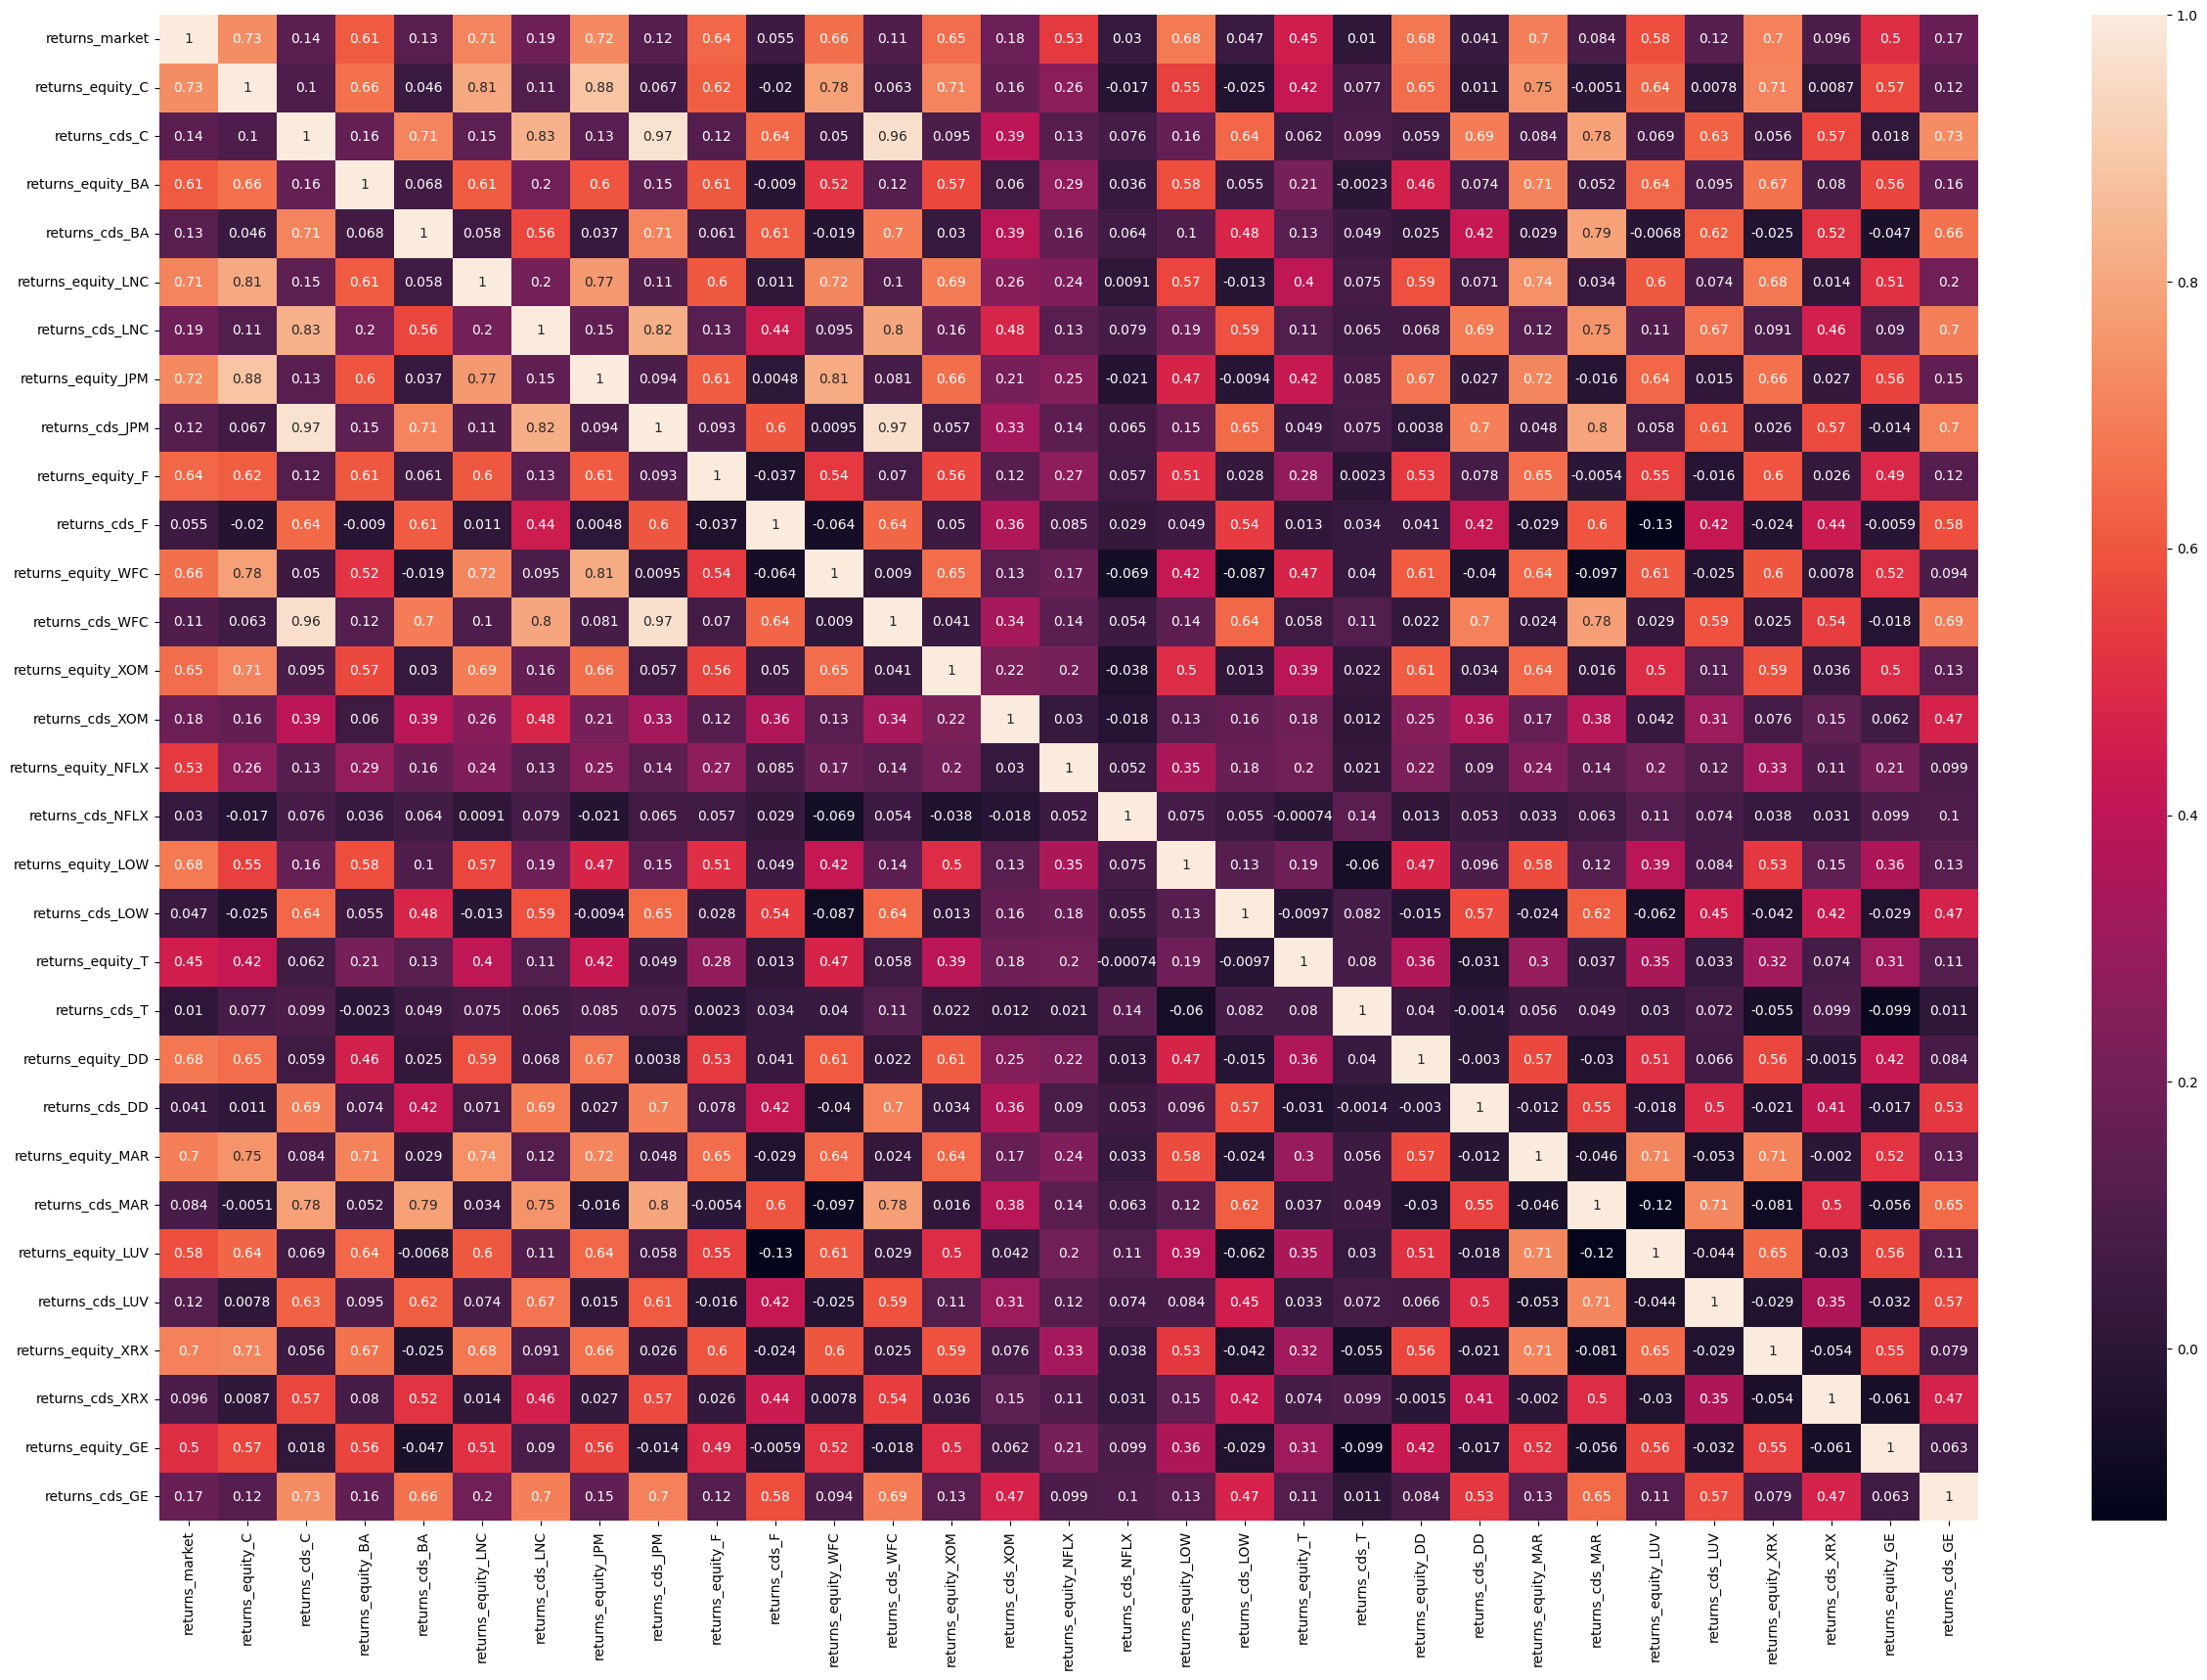

In [61]:
corr_dataframe= pd.DataFrame()
corr_dataframe['returns_market']= spy_data['returns_market']
for ticker in unique_tickers:
    corr_dataframe['returns_equity_'+ ticker]= etf_df_dic[ticker]['returns_equity']
    corr_dataframe['returns_cds_'+ ticker]= etf_df_dic[ticker]['returns_cds']
corr_matrix =corr_dataframe.corr()
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_matrix, annot=True) 

### Analysis of Correlation matrix
This is a complicated correlation matrix but some of the key things to note after an indepth observation of the matrix.
1. The market returns is generally more correlated with the equity returns as compared to the cds spread returns.
2. The correlation between the equity returns and the cds spread returns of the same ticker are quite low and hover around 0.
3. The equity returns of different tickers and the cds spread returns of different tickers are moderatly correlated.

In [273]:
# creating an r index return 
r_cds_average = pd.DataFrame()
for ticker in unique_tickers:
    df= etf_df_dic[ticker]
    r_cds_average[ticker]= df['returns_cds']
    
r_index=pd.DataFrame()
for ticker in unique_tickers:
    r_index[ticker]= r_cds_average.drop(ticker, axis=1).mean(axis=1)
r_index.head()    


C        BA       LNC       JPM         F       WFC  \
date                                                                     
2018-01-10 -0.007952 -0.004015 -0.006599 -0.010178 -0.009355 -0.008281   
2018-01-17  0.038698  0.031941  0.037442  0.038101  0.036847  0.037687   
2018-01-24  0.079640  0.080063  0.080236  0.082502  0.069633  0.081984   
2018-01-31 -0.001899 -0.003056 -0.002612 -0.002665 -0.004409 -0.002331   
2018-02-07  0.096332  0.086041  0.099053  0.095823  0.095758  0.094707   

                 XOM      NFLX       LOW         T        DD       MAR  \
date                                                                     
2018-01-10 -0.007327 -0.008112 -0.002908 -0.008108 -0.009004 -0.010762   
2018-01-17  0.038921  0.039928  0.005136  0.037554  0.035393  0.029989   
2018-01-24  0.084874  0.083408  0.066040  0.082258  0.076817  0.077242   
2018-01-31 -0.003951 -0.005362 -0.005766 -0.003767 -0.006219  0.002119   
2018-02-07  0.104315  0.107196  0.090658  0.104548  0.089561  0.085973   

                 LUV       XRX        GE  
date                                      
2018-01-10 -0.011393 -0.000969 -0.008807  
2018-01-17  0.032892  0.054340  0.032193  
2018-01-24  0.079142  0.070194  0.056478  
2018-01-31 -0.008755 -0.001926 -0.003173  
2018-02-07  0.090896  0.130195  0.097088

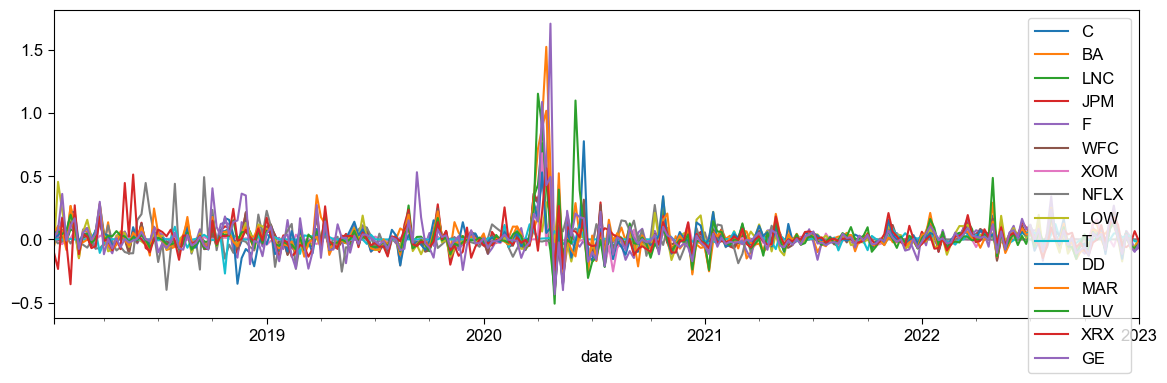

In [282]:
fig, ax = plt.subplots(figsize=(14, 4))
r_cds_average.plot(ax=ax)
ax.legend(r_cds_average.columns)
plt.show()

1. The returns of the CDS spreads of all the equities follow a similar trend. 

2. The returns on cds spreads were high in 2020. The main reason for this could be the COVID-19 pandemic: The outbreak of COVID-19 caused widespread market disruption and volatility, which created opportunities for investors to profit from trading CDS spreads. Oil Price Volatility: In early 2020, oil prices plummeted due to a price war between Russia and Saudi Arabia, which added to market uncertainty and volatility. The oil price movements impacted various industries and sectors, which in turn affected the prices of CDS spreads.

3. Some minor trends that can be observes is that in midd 2019, the returns with ticker netflix were very volatile. This could be because of increased Competition: In 2019, Netflix faced increasing competition from other streaming services, such as Amazon Prime, Hulu, and Disney. The entry of new players and the increasing market share of existing ones created uncertainty about Netflix's future growth prospects, leading to market volatility.

### 5. Description of Models

Predictive regression is aimed at predicting assets.

1. Contemporaneous: refers to data that are measured at the same point in time. For example, in a contemporaneous analysis of stock prices and company earnings, both variables are measured for the same period, such as the same quarter or year. Contemporaneous analysis is often used to study the relationship between variables at a specific point in time, such as the correlation between two stocks in a particular industry.

2. Forward-looking: refers to data that are used to make predictions about future events or trends. For example, in a forward-looking analysis of a company's stock price, analysts might use information about the company's future earnings prospects, growth potential, or other factors that are expected to affect the company's future performance. Forward-looking analysis is often used in forecasting or financial modeling to project future trends.

3. Backward-looking: refers to data that are used to analyze past events or trends. For example, in a backward-looking analysis of a company's stock price, analysts might look at historical data on the company's earnings, revenue, or other financial indicators to understand the factors that have influenced the stock price in the past. Backward-looking analysis is often used to assess the performance of investments, evaluate the effectiveness of policies, or study the impact of economic events.

#### Boxcar Algorithm OLS
Typical window size: 16

#### Exponentially Decaying Regression
Typical half-life: 12

### 6. CAPM - Model

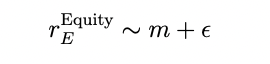

In [65]:
def boxcar_16_reg_capm(_df, ticker):
    _p = linreg.OLS(_df['y'], _df['returns_market_'+ticker]).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])

In [66]:
capm_result_dic={}
for ticker in unique_tickers:
    new_spy= spy_data #?
    dataframe_for_regression= pd.DataFrame()
    df= etf_df_dic[ticker]
    dataframe_for_regression['y']= (df['returns_equity'])
    dataframe_for_regression['returns_market_'+ticker]= (spy_data['returns_market'])
    dataframe_for_regression.dropna(inplace= True)
    b_16_coeffs = pd.concat([boxcar_16_reg_capm(dataframe_for_regression.iloc[i-16:i], ticker) for i in range(16, dataframe_for_regression.shape[0])])
    capm_result_dic[ticker]= b_16_coeffs 

In [67]:
#an example of the beta coeffecients of one ticker
capm_beta_coeffecient= pd.DataFrame()
for ticker in unique_tickers:
    df= capm_result_dic[ticker]
    capm_beta_coeffecient[df.columns[0]+"_beta"]= df.iloc[:, 0]

### 7. CAPM- Analysis

In [68]:
capm_beta_coeffecient.head()

returns_market_C_beta  returns_market_BA_beta  \
2018-04-25               0.822387                0.816514   
2018-05-02               0.820549                0.696447   
2018-05-09               0.953703                0.615251   
2018-05-16               0.913058                0.702168   
2018-05-23               0.890454                0.775872   

            returns_market_LNC_beta  returns_market_JPM_beta  \
2018-04-25                 0.961894                 0.715327   
2018-05-02                 0.854078                 0.686917   
2018-05-09                 0.818395                 0.776904   
2018-05-16                 0.826026                 0.737264   
2018-05-23                 0.838303                 0.732997   

            returns_market_F_beta  returns_market_WFC_beta  \
2018-04-25               0.258805                 1.201914   
2018-05-02               0.219861                 1.186870   
2018-05-09               0.361658                 1.255875   
2018-05-16               0.432619                 1.255451   
2018-05-23               0.389519                 1.272102   

            returns_market_XOM_beta  returns_market_NFLX_beta  \
2018-04-25                 1.224163                  2.114587   
2018-05-02                 1.281183                  2.091156   
2018-05-09                 1.327330                  2.160728   
2018-05-16                 1.383655                  1.782502   
2018-05-23                 1.375893                  1.838219   

            returns_market_LOW_beta  returns_market_T_beta  \
2018-04-25                 0.946218               0.238710   
2018-05-02                 0.916273               0.297400   
2018-05-09                 0.673546               0.197281   
2018-05-16                 0.596201               0.234131   
2018-05-23                 0.650457               0.242756   

            returns_market_DD_beta  returns_market_MAR_beta  \
2018-04-25                1.547017                 1.094558   
2018-05-02                1.557608                 1.111346   
2018-05-09                1.597405                 1.089054   
2018-05-16                1.652134                 1.094686   
2018-05-23                1.640112                 1.098406   

            returns_market_LUV_beta  returns_market_XRX_beta  \
2018-04-25                 0.907676                 1.362702   
2018-05-02                 1.002414                 1.338504   
2018-05-09                 0.784200                 1.082229   
2018-05-16                 0.946916                 1.050522   
2018-05-23                 0.900444                 1.077084   

            returns_market_GE_beta  
2018-04-25                0.292399  
2018-05-02                0.209255  
2018-05-09                0.564701  
2018-05-16                0.713816  
2018-05-23                0.667872

In [127]:
capm_residuals= pd.DataFrame()
capm_prediction= pd.DataFrame()
for ticker in unique_tickers:
    df= etf_df_dic[ticker]
    capm_residuals[ticker]= df['returns_equity'][15:]- capm_beta_coeffecient['returns_market_'+ticker+'_beta']*spy_data['returns_market'][15:]
    capm_prediction[ticker]= capm_beta_coeffecient['returns_market_'+ticker+'_beta']*spy_data['returns_market'][15:]
capm_residuals.head() 

C        BA       LNC       JPM         F       WFC  \
date                                                                     
2018-04-25  0.026069  0.025868  0.039012  0.024013  0.000473  0.084028   
2018-05-02 -0.018414 -0.053318 -0.056743 -0.017699  0.009360 -0.015387   
2018-05-09  0.040400  0.047922 -0.021509  0.032275 -0.022038  0.007816   
2018-05-16 -0.009283 -0.012467 -0.002776 -0.008113  0.026343  0.011045   
2018-05-23 -0.027430  0.050302  0.022739 -0.010515  0.001906  0.015479   

                 XOM      NFLX       LOW         T        DD       MAR  \
date                                                                     
2018-04-25  0.034140 -0.033107 -0.028734  0.005684 -0.026266  0.019629   
2018-05-02 -0.031873  0.028267  0.031931 -0.088719  0.000184 -0.020630   
2018-05-09  0.008984  0.002340 -0.010643 -0.025309  0.001771  0.001809   
2018-05-16  0.022433 -0.024511  0.006850  0.026282  0.013492  0.007290   
2018-05-23 -0.004075  0.042805  0.104680 -0.000070 -0.021300 -0.021908   

                 LUV       XRX        GE  
date                                      
2018-04-25 -0.012958  0.046292  0.035861  
2018-05-02 -0.028460 -0.038940  0.009594  
2018-05-09 -0.031220 -0.044625  0.017513  
2018-05-16  0.018495 -0.020393  0.020786  
2018-05-23 -0.054450 -0.022645 -0.059301

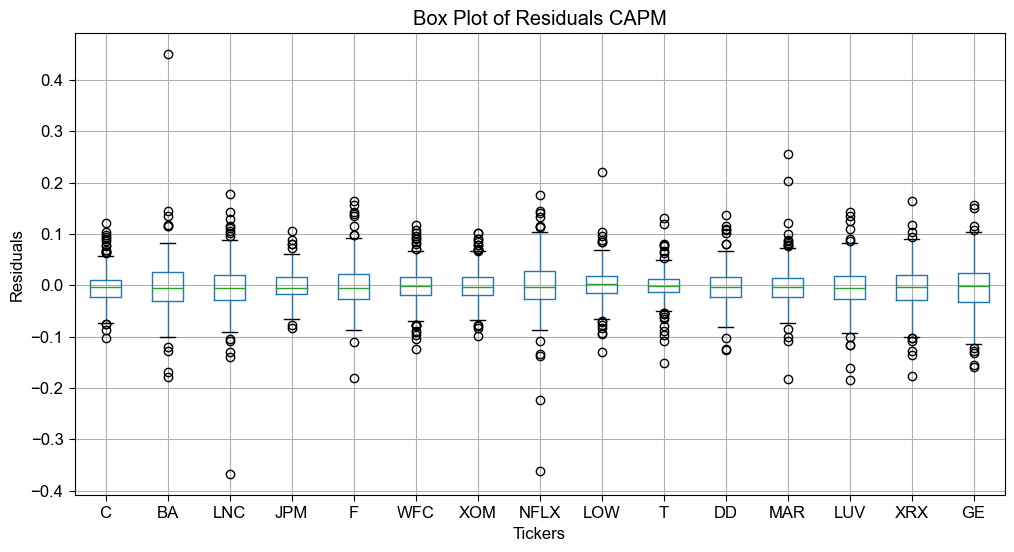

In [283]:
fig, ax = plt.subplots(figsize=(12, 6))
capm_residuals.boxplot(column= ['C', 'BA', 'LNC', 'JPM', 'F', 'WFC', 'XOM', 'NFLX', 'LOW', 'T', 'DD', 'MAR', 'LUV', 'XRX', 'GE'], ax=ax)
ax.set_xlabel('Tickers')
ax.set_ylabel('Residuals')
ax.set_title('Box Plot of Residuals CAPM')
plt.show()

A boxplot of residuals represents the distribution of the residuals, which are the differences between the observed values and the predicted values in a regression model.

1. The largest interquartile range is for netflix meaning the data(residuals) are more spread out. 

2. For most the boxplot is symmetric indicating there is no skewness.

3. All the  tickers have outliers, netflix however has the furtherest outliers. 

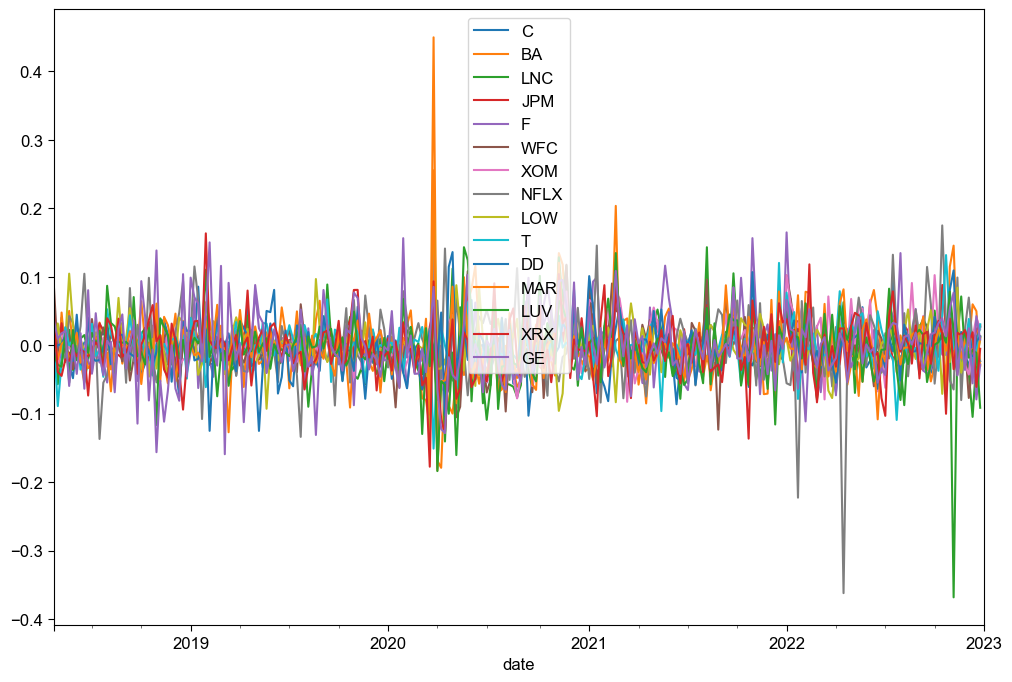

In [284]:
fig, ax = plt.subplots(figsize=(12, 8))
capm_residuals.plot(ax=ax)
ax.legend(capm_residuals.columns, fontsize=12)
plt.ylabel()
plt.show()

Three main points got from this time-series plot.
1. Residual of BA during 2020 is very high. The boeing company has a big error in 2020 because of the volatility on the market and the lockdown which caused the stocks of the company to plummet.
2. Residual of NFLX during 2022 is very high. This could be due to competition from other streaming services.
3. Residual of LNC during late 2022 is very high. This could be due to the expectation of recession and the econmic conditions affect the returns of the cds spread tremendously.

In [285]:
r2_score_dic={}
for ticker in unique_tickers:
    df= etf_df_dic[ticker]
    r2_score_dic[ticker]= r2_score(df['returns_equity'][15:245], capm_prediction[ticker][:230])
r2_df = pd.DataFrame(r2_score_dic, index= ['R2_SCORE'])
display(r2_df.T)

R2_SCORE
C     0.601540
BA    0.506491
LNC   0.640752
JPM   0.555255
F     0.440352
WFC   0.447209
XOM   0.496747
NFLX  0.380743
LOW   0.554776
T     0.220882
DD    0.494516
MAR   0.560998
LUV   0.376341
XRX   0.548303
GE    0.336883

#### The threshold of r2-score:
A good R-squared (R2) score typically depends on the context and purpose of the analysis. In general, R2 is a statistical measure that represents the proportion of variance in the dependent variable (the variable being predicted) that is explained by the independent variable(s) (the predictors) in a regression model.

R2 can range from 0 to 1, where a value of 1 indicates that the model explains all of the variance in the dependent variable, and a value of 0 indicates that the model does not explain any of the variance. However, it is rare to achieve an R2 of 1 in practice, and a good R2 score can vary depending on the field of study and the complexity of the model.

 However, generally speaking, an R2 score of 0.5 or higher may be considered a good fit for a regression model in finance, including CDS spread returns.

Hnece, the model does decent. For LNC the CAPM model does the best and for the ticker T, the CAPM model doesn the best. 

Reasoning: 
The credit default swap (CDS) spreads of LNC may be well explained by market factors for a number of reasons, including: Correlation with market factors: The creditworthiness of LNC can be affected by a range of market factors such as interest rates, equity market performance, and economic conditions. These factors can also influence the demand for insurance and investment products that LNC offers. 

### Contemporaneous Model for returns for CDS Spread

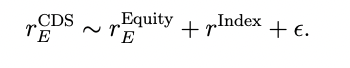

In [152]:
def boxcar_16_reg_returns_cds(_df, ticker):
    _p = linreg.OLS(_df['y'], _df[['returns_equity_'+ticker, 'returns_index_'+ticker]]).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])

In [153]:
cds_result_dic={}
for ticker in unique_tickers:
    new_spy= spy_data
    dataframe_for_regression= pd.DataFrame()
    df= etf_df_dic[ticker]
    dataframe_for_regression['returns_equity_'+ticker]= (df['returns_equity'])
    dataframe_for_regression['returns_index_'+ticker]= r_index[ticker]
    dataframe_for_regression['y']= (df['returns_cds'])
    dataframe_for_regression.dropna(inplace= True)
    b_16_coeffs = pd.concat([boxcar_16_reg_returns_cds(dataframe_for_regression.iloc[i-16:i], ticker) for i in range(16, dataframe_for_regression.shape[0])])
    cds_result_dic[ticker]= b_16_coeffs

In [156]:
cds_beta_coeffecient= pd.DataFrame()
for ticker in unique_tickers:
    df= cds_result_dic[ticker]
    cds_beta_coeffecient[df.columns[0]]= df.iloc[:, 0]
    cds_beta_coeffecient[df.columns[1]]= df.iloc[:, 1]

In [157]:
cds_beta_coeffecient.head()

returns_equity_C  returns_index_C  returns_equity_BA  \
2018-04-25         -0.096489         1.059204           0.047233   
2018-05-02         -0.135877         1.054593           0.140352   
2018-05-09         -0.133632         1.072814           0.031015   
2018-05-16          0.061125         1.198360          -0.104848   
2018-05-23         -0.009870         1.214504          -0.234664   

            returns_index_BA  returns_equity_LNC  returns_index_LNC  \
2018-04-25          1.591813           -0.354715           0.807884   
2018-05-02          1.612079           -0.336635           0.813699   
2018-05-09          1.571031           -0.297280           0.839646   
2018-05-16          1.702949           -0.174171           0.912045   
2018-05-23          1.644396           -0.199365           0.900517   

            returns_equity_JPM  returns_index_JPM  returns_equity_F  \
2018-04-25           -0.177369           0.906834          0.142243   
2018-05-02           -0.399459           0.891722          0.098714   
2018-05-09           -0.391275           0.901048         -0.101449   
2018-05-16           -0.030329           1.083204          0.088764   
2018-05-23           -0.030620           1.078110          0.234914   

            returns_index_F  ...  returns_equity_DD  returns_index_DD  \
2018-04-25         1.177376  ...          -0.290939          1.593638   
2018-05-02         1.175531  ...          -0.321305          1.590018   
2018-05-09         1.183468  ...          -0.398594          1.554718   
2018-05-16         1.049184  ...          -0.258224          1.621924   
2018-05-23         1.014982  ...          -0.257564          1.556461   

            returns_equity_MAR  returns_index_MAR  returns_equity_LUV  \
2018-04-25           -1.011699           1.341594           -0.324614   
2018-05-02           -1.121373           1.340493           -0.250123   
2018-05-09           -1.499026           1.222718           -0.496496   
2018-05-16           -1.467162           1.205011           -0.672238   
2018-05-23           -1.333642           1.190002           -0.294424   

            returns_index_LUV  returns_equity_XRX  returns_index_XRX  \
2018-04-25           0.985781           -0.573619           0.065307   
2018-05-02           1.014595           -0.184841           0.203219   
2018-05-09           0.905464            0.900230           0.982015   
2018-05-16           0.918283            0.225730           0.491759   
2018-05-23           0.970388            0.022256           0.574801   

            returns_equity_GE  returns_index_GE  
2018-04-25          -0.191950          1.890443  
2018-05-02          -0.331782          1.838697  
2018-05-09          -0.587492          1.738925  
2018-05-16           0.321658          1.628297  
2018-05-23           0.598143          1.604656  

[5 rows x 30 columns]

In [159]:
rcds_residuals= pd.DataFrame()
rcds_prediction= pd.DataFrame()
for ticker in unique_tickers:
    df= etf_df_dic[ticker]
    rcds_residuals[ticker]= df['returns_cds'][15:]- df['returns_equity'][15:]*cds_beta_coeffecient['returns_equity_'+ticker]+ r_index[ticker][15:]*cds_beta_coeffecient['returns_index_'+ticker]
    rcds_prediction[ticker]= capm_beta_coeffecient['returns_market_'+ticker+'_beta']*spy_data['returns_market'][15:]
rcds_residuals.head() 

C        BA       LNC       JPM         F       WFC  \
date                                                                     
2018-04-25 -0.032946 -0.025120 -0.008802 -0.024322 -0.004054  0.016705   
2018-05-02  0.021203  0.047689 -0.005087  0.022121  0.009671  0.022097   
2018-05-09  0.066822  0.120061  0.062520  0.061351  0.105039  0.053999   
2018-05-16 -0.125093 -0.148899 -0.043114 -0.132396 -0.047336 -0.136394   
2018-05-23  0.160144  0.152390  0.099751  0.114909  0.067790  0.116752   

                 XOM      NFLX       LOW         T        DD       MAR  \
date                                                                     
2018-04-25  0.031462 -0.082897  0.103115  0.002829 -0.042332 -0.056565   
2018-05-02 -0.006258 -0.064506  0.002867 -0.020371  0.023072  0.040102   
2018-05-09 -0.001467 -0.114846  0.109822 -0.015476  0.099396  0.088957   
2018-05-16 -0.000169 -0.101199 -0.110798  0.020127 -0.086685 -0.069370   
2018-05-23  0.025109 -0.127013  0.134914 -0.014223  0.113246  0.094479   

                 LUV       XRX        GE  
date                                      
2018-04-25  0.043429  0.012262  0.001831  
2018-05-02  0.026668 -0.082481 -0.040170  
2018-05-09  0.054274  0.473552  0.096481  
2018-05-16 -0.042425  0.002042 -0.103013  
2018-05-23  0.059695  0.526464  0.121165

### 9. Contemporaneous Model for returns for CDS Spread- Analysis

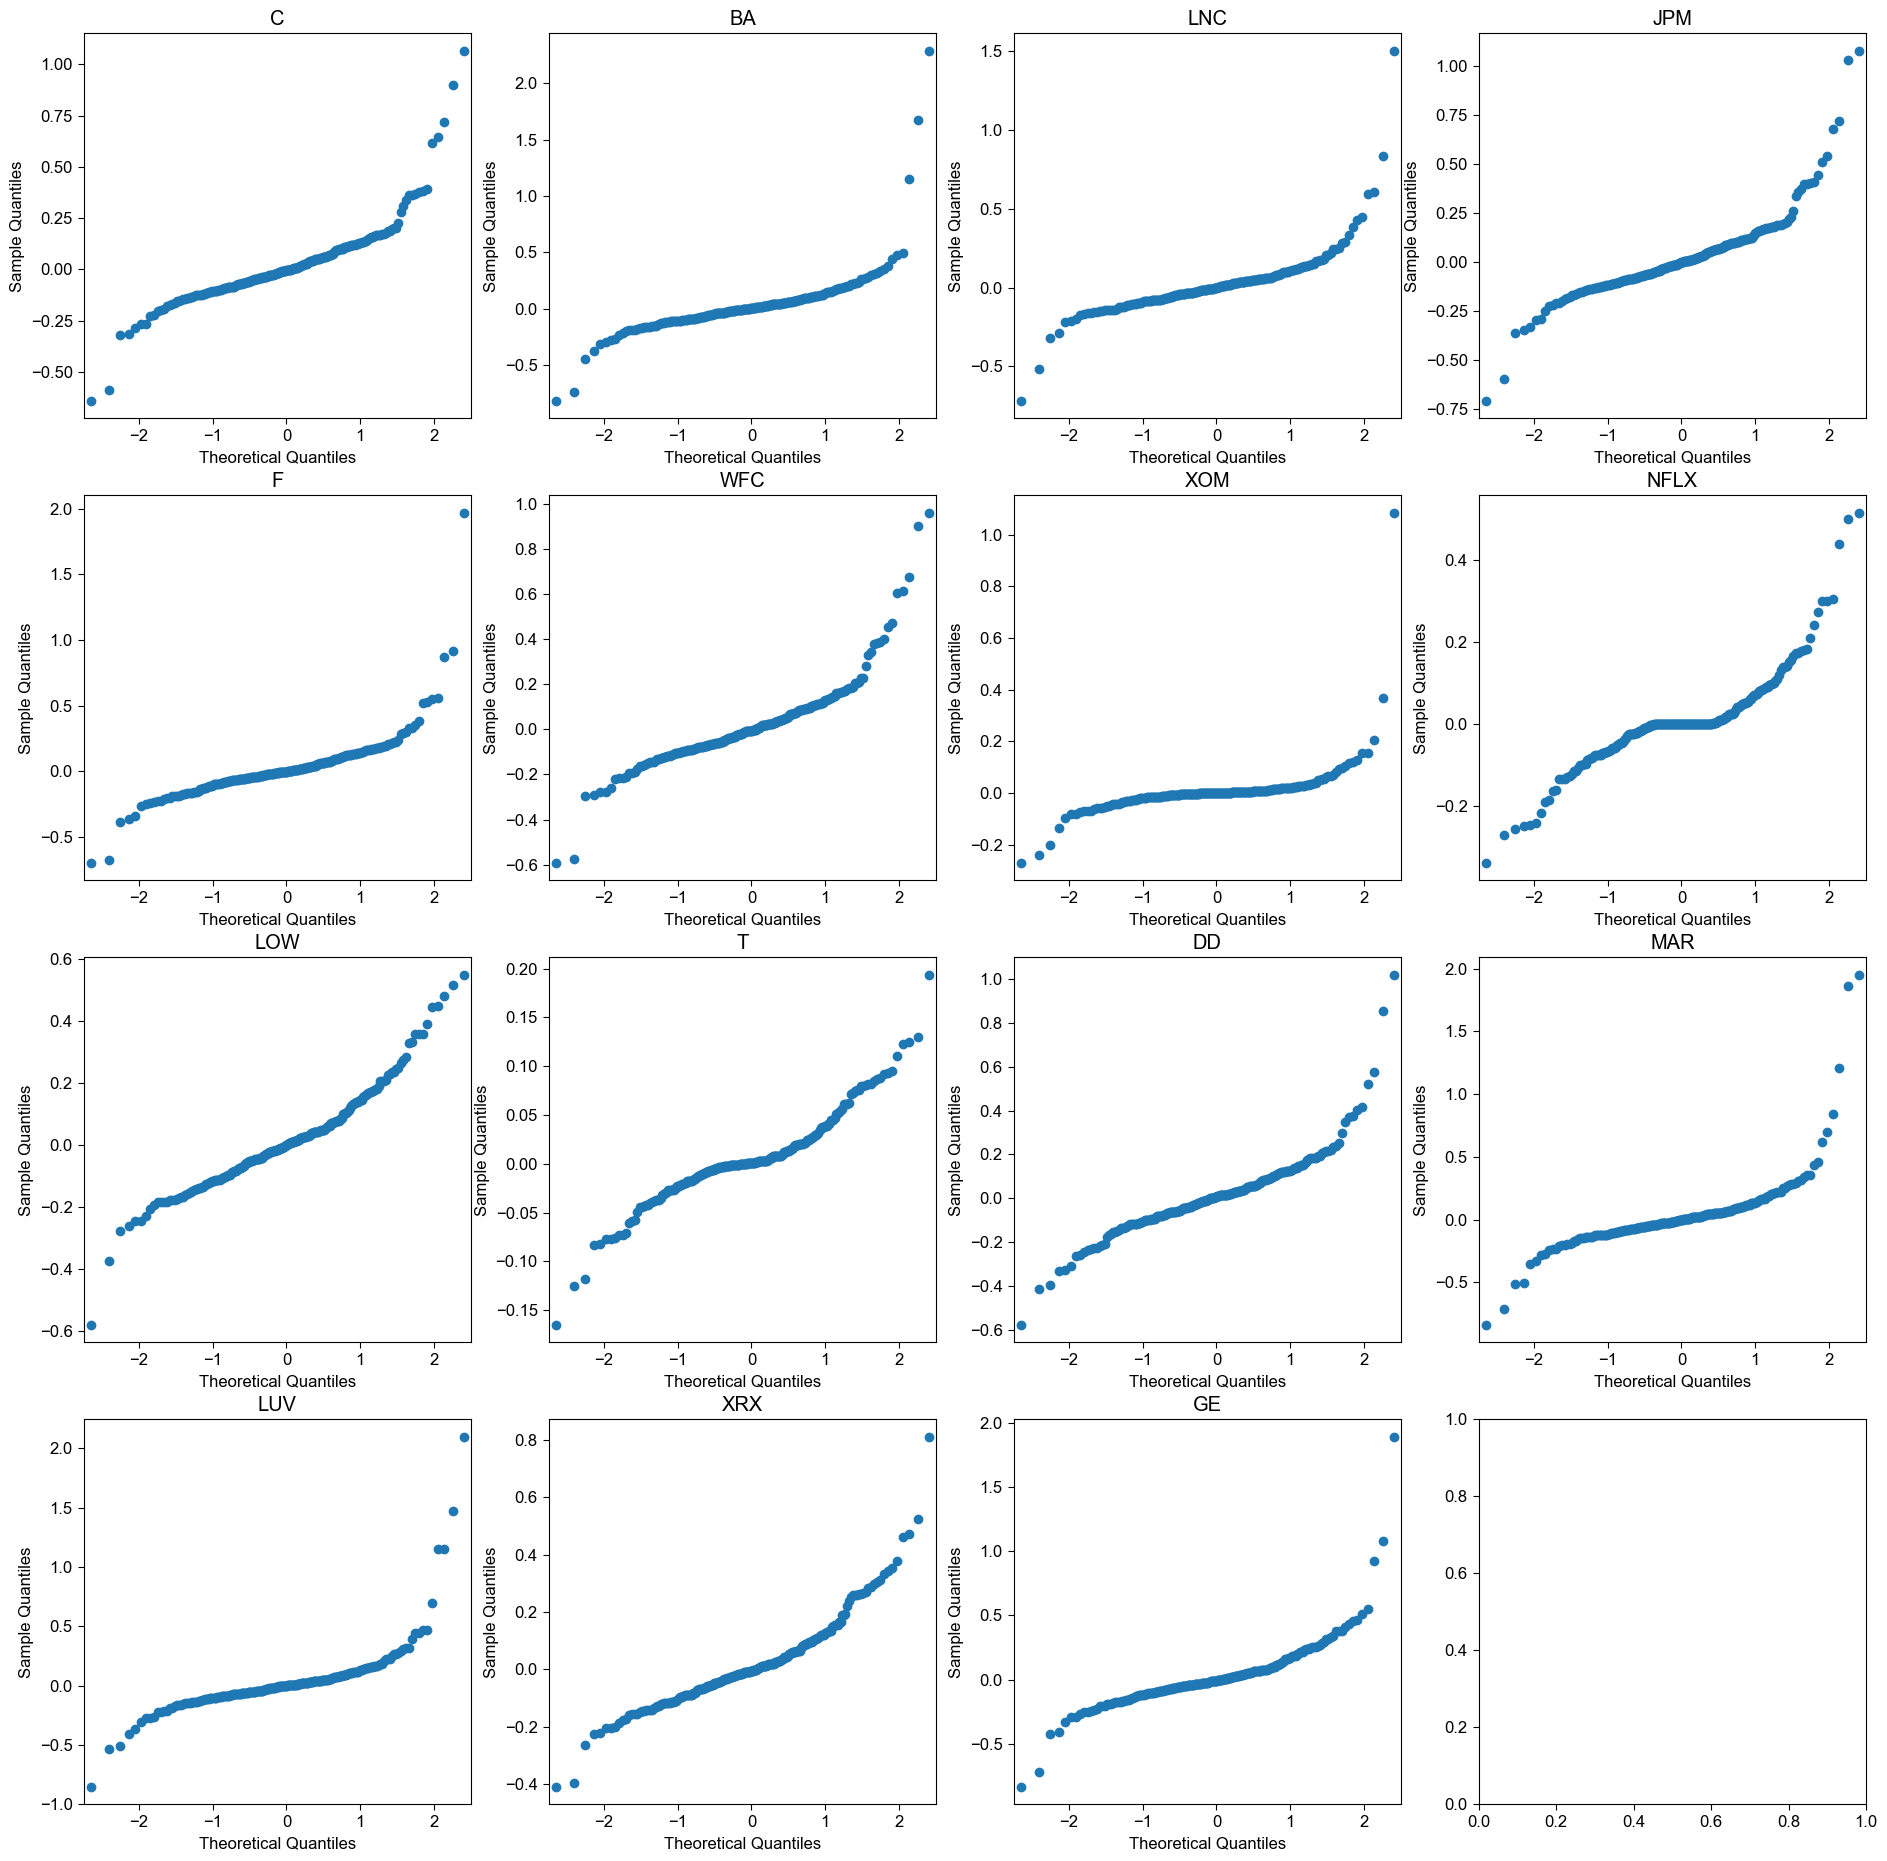

In [295]:
fig, axs = plt.subplots(nrows=4, ncols=4,  figsize=(23, 23))
df=rcds_residuals
for i, col in enumerate(df.columns):
    sm.qqplot(df[col], ax=axs[int(i/4)][i%4])
    axs[int(i/4)][i%4].set_title(col)

Q-Q analysis, or quantile-quantile analysis, is a statistical method used to assess whether a dataset follows a particular probability distribution. The Q-Q plot is a graphical representation of this analysis, which can be used to visually compare the distribution of a dataset to a theoretical distribution.

Examine the slope of the line: In a Q-Q plot, if the slope of the line connecting the points is approximately 45 degrees, it indicates that the dataset being compared to the theoretical distribution is normally distributed. Here, we have quite a few graphs where the slope looks like it is far from the slope of 45 and have a shallower slope. This indicates that the residuals are more tightly clustered around the mean than the theoretical distribution.

In [160]:
r2_score_dic={}
for ticker in unique_tickers:
    df= etf_df_dic[ticker]
    r2_score_dic[ticker]= r2_score(df['returns_cds'][15:245], rcds_prediction[ticker][:230])
r2_df = pd.DataFrame(r2_score_dic, index= ['R2_SCORE'])
display(r2_df.T)

R2_SCORE
C    -0.026481
BA    0.012990
LNC  -0.044803
JPM  -0.017286
F    -0.038141
WFC  -0.044353
XOM  -0.016625
NFLX -0.179138
LOW  -0.141191
T    -0.198796
DD   -0.103221
MAR  -0.039932
LUV   0.000454
XRX  -0.140048
GE    0.033974

The R2 scores here are not great and the R2 scores in the CAPM model are much better. This is as expected because we saw that the market return and equity returns are very correlated which means that the market can explain it. This indicates that the current r_index (which is the avrega of all the tickers but the ticker we are measuring) does not do a good job in  predicting the returns of the cds spreads for that ticker.

### 10. Creation of hedge portfolio return

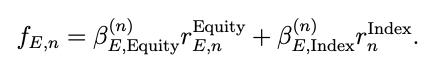

In [184]:
#creation of a hedging portfolio
hedging_portfolio= pd.DataFrame()
counter=0
for ticker in unique_tickers:
    temp_df= pd.DataFrame()
    temp_df['betas_equity']= cds_beta_coeffecient.iloc[:, counter]
    temp_df['betas_index']= cds_beta_coeffecient.iloc[:, counter+1]
    df= etf_df_dic[ticker]
    temp_df['returns_equity']= df['returns_equity']
    temp_df['returns_index']= r_index[ticker]
    temp_df['f']= temp_df['betas_equity']* temp_df['returns_equity']- temp_df['betas_index']*temp_df['returns_equity']
    hedging_portfolio['f_'+ticker]= temp_df['f']
    

In [185]:
hedging_portfolio.head()

f_C      f_BA     f_LNC     f_JPM       f_F     f_WFC  \
2018-04-25 -0.006367 -0.006304 -0.017293 -0.007083  0.006931 -0.062383   
2018-05-02  0.023514  0.064825  0.069209  0.022405 -0.010715  0.020622   
2018-05-09 -0.076281 -0.075582  0.002316 -0.061373  0.016143 -0.045697   
2018-05-16  0.000000  0.006059 -0.006394  0.000702 -0.034960 -0.027077   
2018-05-23  0.029099 -0.065497 -0.032064  0.009182 -0.004296 -0.025360   

               f_XOM    f_NFLX     f_LOW       f_T      f_DD     f_MAR  \
2018-04-25 -0.004085  0.099359  0.060547  0.000328  0.075054  0.008941   
2018-05-02  0.040431 -0.029590 -0.036234  0.106195  0.002806  0.026717   
2018-05-09 -0.049169 -0.065220 -0.006610  0.024836 -0.048265 -0.033632   
2018-05-16 -0.041509  0.007265 -0.014684 -0.032596 -0.034446 -0.020947   
2018-05-23 -0.001941 -0.061668 -0.131444 -0.001137  0.017818  0.021290   

               f_LUV     f_XRX      f_GE  
2018-04-25  0.041201 -0.014126 -0.032996  
2018-05-02  0.035827  0.048955 -0.011015  
2018-05-09  0.015020  0.022585 -0.037436  
2018-05-16 -0.031982  0.011045 -0.031892  
2018-05-23  0.062131  0.022300  0.069243

### 11. Calculation of Residual Return

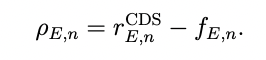

In [189]:
residual_error= pd.DataFrame()
for ticker in unique_tickers:
    df= etf_df_dic[ticker]
    temp_df= pd.DataFrame()
    temp_df['returns_cds']= df['returns_cds'][15:]
    temp_df['f']= (hedging_portfolio['f_' + ticker])
    residual_error['p_'+ ticker]= temp_df['returns_cds']- temp_df['f']

In [190]:
residual_error.head()

p_C      p_BA     p_LNC     p_JPM       p_F     p_WFC  \
date                                                                     
2018-04-25 -0.022739 -0.010600  0.007641 -0.014067 -0.004309  0.057495   
2018-05-02 -0.004383 -0.030274 -0.058909  0.003654  0.014701  0.007415   
2018-05-09  0.089876  0.137427  0.026650  0.064539  0.044864  0.046624   
2018-05-16 -0.078653 -0.088916  0.002517 -0.092087  0.037064 -0.087145   
2018-05-23  0.067527  0.113279  0.075930  0.046187  0.013277  0.081382   

               p_XOM    p_NFLX     p_LOW       p_T      p_DD     p_MAR  \
date                                                                     
2018-04-25  0.036852 -0.187212 -0.035386  0.000972 -0.090339 -0.053634   
2018-05-02 -0.047722 -0.031262  0.092958 -0.105410  0.013536  0.036751   
2018-05-09  0.040687 -0.034823  0.055866 -0.024641  0.067442  0.028094   
2018-05-16  0.055888 -0.117659 -0.044839  0.032465  0.008953 -0.026021   
2018-05-23  0.013344 -0.048174  0.150577  0.002090  0.009803  0.030065   

               p_LUV     p_XRX      p_GE  
date                                      
2018-04-25  0.024550  0.019808  0.042343  
2018-05-02 -0.005388 -0.126150 -0.051201  
2018-05-09  0.008269  0.423460  0.041981  
2018-05-16  0.009953  0.011413  0.007288  
2018-05-23 -0.043864  0.490680 -0.078243

### 12. Calculation of Residual Equity Return

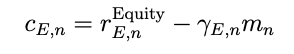

In [191]:
residual_equity_error= pd.DataFrame()
for ticker in unique_tickers:
    df= etf_df_dic[ticker]
    temp_df= pd.DataFrame()
    temp_df['returns_equity']= df['returns_equity'][15:]
    temp_df['gamma']= capm_beta_coeffecient['returns_market_' + ticker + '_beta']
    residual_equity_error['c_'+ ticker]= temp_df['returns_equity']- temp_df['gamma']

In [202]:
residual_equity_error.head()

c_C      c_BA     c_LNC     c_JPM       c_F     c_WFC  \
date                                                                     
2018-04-25 -0.816878 -0.811059 -0.946931 -0.709199 -0.264802 -1.147935   
2018-05-02 -0.840301 -0.750901 -0.912214 -0.705737 -0.210860 -1.204192   
2018-05-09 -0.890475 -0.552603 -0.820314 -0.726033 -0.375039 -1.217998   
2018-05-16 -0.913058 -0.707495 -0.820403 -0.737881 -0.401877 -1.231641   
2018-05-23 -0.914221 -0.722378 -0.812115 -0.740496 -0.386010 -1.251390   

               c_XOM    c_NFLX     c_LOW       c_T      c_DD     c_MAR  \
date                                                                     
2018-04-25 -1.220629 -2.200561 -0.998609 -0.238994 -1.611960 -1.102294   
2018-05-02 -1.315145 -2.066300 -0.885836 -0.386604 -1.559965 -1.133788   
2018-05-09 -1.286575 -2.106669 -0.668067 -0.217867 -1.557399 -1.061177   
2018-05-16 -1.347155 -1.788890 -0.583290 -0.205469 -1.621844 -1.076266   
2018-05-23 -1.374308 -1.787852 -0.543101 -0.241827 -1.654665 -1.115795   

               c_LUV     c_XRX      c_GE  
date                                      
2018-04-25 -0.943326 -1.350479 -0.263849  
2018-05-02 -1.032509 -1.379627 -0.200003  
2018-05-09 -0.796650 -1.100949 -0.533672  
2018-05-16 -0.918793 -1.060234 -0.685772  
2018-05-23 -0.951189 -1.095298 -0.724426

In [203]:
residual_equity_error_shifted= residual_equity_error.shift(1, axis=0)
residual_equity_error_shifted.head()

c_C      c_BA     c_LNC     c_JPM       c_F     c_WFC  \
date                                                                     
2018-04-25       NaN       NaN       NaN       NaN       NaN       NaN   
2018-05-02 -0.816878 -0.811059 -0.946931 -0.709199 -0.264802 -1.147935   
2018-05-09 -0.840301 -0.750901 -0.912214 -0.705737 -0.210860 -1.204192   
2018-05-16 -0.890475 -0.552603 -0.820314 -0.726033 -0.375039 -1.217998   
2018-05-23 -0.913058 -0.707495 -0.820403 -0.737881 -0.401877 -1.231641   

               c_XOM    c_NFLX     c_LOW       c_T      c_DD     c_MAR  \
date                                                                     
2018-04-25       NaN       NaN       NaN       NaN       NaN       NaN   
2018-05-02 -1.220629 -2.200561 -0.998609 -0.238994 -1.611960 -1.102294   
2018-05-09 -1.315145 -2.066300 -0.885836 -0.386604 -1.559965 -1.133788   
2018-05-16 -1.286575 -2.106669 -0.668067 -0.217867 -1.557399 -1.061177   
2018-05-23 -1.347155 -1.788890 -0.583290 -0.205469 -1.621844 -1.076266   

               c_LUV     c_XRX      c_GE  
date                                      
2018-04-25       NaN       NaN       NaN  
2018-05-02 -0.943326 -1.350479 -0.263849  
2018-05-09 -1.032509 -1.379627 -0.200003  
2018-05-16 -0.796650 -1.100949 -0.533672  
2018-05-23 -0.918793 -1.060234 -0.685772

### 13. Residual Return and Residual Equity Return Model (BoxCar)

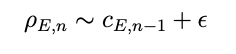

In [195]:
def boxcar_16_reg_residual(_df, ticker):
    _p = linreg.OLS(_df['y'], _df['x']).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])

In [196]:
residual_equity_error_shifted= residual_equity_error_shifted.drop(residual_equity_error_shifted.index[0])
residual_equity_error_shifted= residual_equity_error_shifted.drop(residual_equity_error_shifted.index[-1])
residual_error= residual_error.drop(residual_error.index[0])
residual_error= residual_error.drop(residual_error.index[-1])

In [209]:
coefficients_boxcar=pd.DataFrame()
for ticker in unique_tickers:
    dataframe_for_regression= pd.DataFrame()
    dataframe_for_regression['y']= (residual_error['p_'+ticker])
    dataframe_for_regression['x']= (residual_equity_error_shifted['c_' + ticker])
    dataframe_for_regression.dropna(inplace= True)
    b_16_coeffs = pd.concat([boxcar_16_reg_residual(dataframe_for_regression.iloc[i-16:i], ticker) for i in range(16, dataframe_for_regression.shape[0])])
    coefficients_boxcar[ticker]= (b_16_coeffs)

### 14. Residual Return and Residual Equity Return Model- Analysis (BoxCar)

In [210]:
coefficients_boxcar.head()

C        BA       LNC       JPM         F       WFC  \
2018-08-15 -0.002153  0.006235 -0.002001  0.002681 -0.009159 -0.002316   
2018-08-22 -0.014762 -0.011946 -0.013923 -0.009023 -0.029415 -0.015256   
2018-08-29 -0.005930 -0.002956 -0.010635 -0.000160 -0.026458 -0.005828   
2018-09-05 -0.006535 -0.003727 -0.008574 -0.000142 -0.007209 -0.012219   
2018-09-12 -0.005190 -0.002959 -0.005853 -0.001578 -0.016804 -0.004667   

                 XOM      NFLX       LOW         T        DD       MAR  \
2018-08-15 -0.004129 -0.012855 -0.011209  0.028091  0.001349 -0.000477   
2018-08-22 -0.011186 -0.016625 -0.017404 -0.003874 -0.001061 -0.007416   
2018-08-29 -0.007612 -0.016421 -0.002270 -0.017140  0.002032 -0.005974   
2018-09-05 -0.001839 -0.018488 -0.000560 -0.009911  0.004283 -0.004380   
2018-09-12 -0.000593 -0.013930 -0.002803 -0.001918  0.004820 -0.004729   

                 LUV       XRX        GE  
2018-08-15  0.005126 -0.058434 -0.066914  
2018-08-22  0.004298 -0.077127 -0.064693  
2018-08-29  0.007096 -0.040379 -0.062547  
2018-09-05  0.010124 -0.033795 -0.071832  
2018-09-12  0.005691 -0.004708 -0.107890

In [236]:
residuals_boxcar= pd.DataFrame()
predicted_boxcar= pd.DataFrame()
for ticker in unique_tickers:
    new_dataframe= pd.DataFrame()
    new_dataframe['u']= coefficients_boxcar[ticker]
    new_dataframe['c']= residual_equity_error_shifted['c_'+ticker]
    new_dataframe['p']= residual_error['p_'+ticker]
    new_dataframe['r']= new_dataframe['p']- new_dataframe['c']*new_dataframe['u']
    new_dataframe['predicted']= new_dataframe['c']*new_dataframe['u']
    residuals_boxcar[ticker]= new_dataframe['r']
    predicted_boxcar[ticker]= new_dataframe['predicted']
residuals_boxcar.head() 

C        BA       LNC       JPM         F       WFC  \
2018-08-15 -0.069966 -0.028965 -0.033997 -0.025471 -0.036263 -0.018093   
2018-08-22  0.102278  0.205545  0.074608  0.093916  0.076796  0.100097   
2018-08-29 -0.049548 -0.064606 -0.025828 -0.063539 -0.005028 -0.047829   
2018-09-05 -0.043694 -0.020387 -0.025516 -0.048517 -0.068075 -0.045423   
2018-09-12  0.018724  0.037055  0.016938  0.042992  0.047706  0.006693   

                 XOM      NFLX       LOW         T        DD       MAR  \
2018-08-15 -0.038047 -0.084808 -0.001258  0.009089 -0.044774  0.026246   
2018-08-22  0.023132  0.100360  0.142110 -0.059425  0.118169  0.164169   
2018-08-29 -0.005232 -0.090890 -0.082029 -0.010910 -0.034402 -0.010681   
2018-09-05  0.002704 -0.086053 -0.031583  0.000134 -0.068554 -0.056442   
2018-09-12  0.006606 -0.221900  0.074560  0.042423  0.002593  0.026645   

                 LUV       XRX        GE  
2018-08-15 -0.013954 -0.023478 -0.088747  
2018-08-22  0.060269  0.002801  0.075239  
2018-08-29 -0.073126 -0.071669 -0.000316  
2018-09-05 -0.037146 -0.087911 -0.028659  
2018-09-12  0.002750  0.025015  0.049887

In [225]:
#r2_score
r2_score_dic={}
for ticker in unique_tickers:
    r2_score_dic[ticker]= r2_score(residual_error['p_'+ticker][20:], predicted_boxcar[ticker][4:])
r2_df = pd.DataFrame(r2_score_dic, index= ['R2_SCORE'])
display(r2_df.T)

R2_SCORE
C    -0.096398
BA   -0.171254
LNC  -0.091454
JPM  -0.082036
F    -0.113901
WFC  -0.115873
XOM  -0.136286
NFLX -0.046215
LOW  -0.085929
T    -0.076113
DD   -0.093904
MAR  -0.077354
LUV  -0.077499
XRX  -0.063647
GE   -0.089672

Here agin the Rs score is not that great. Hence, the residual equity does not do a great job in regressing the residual returns.

<AxesSubplot: >

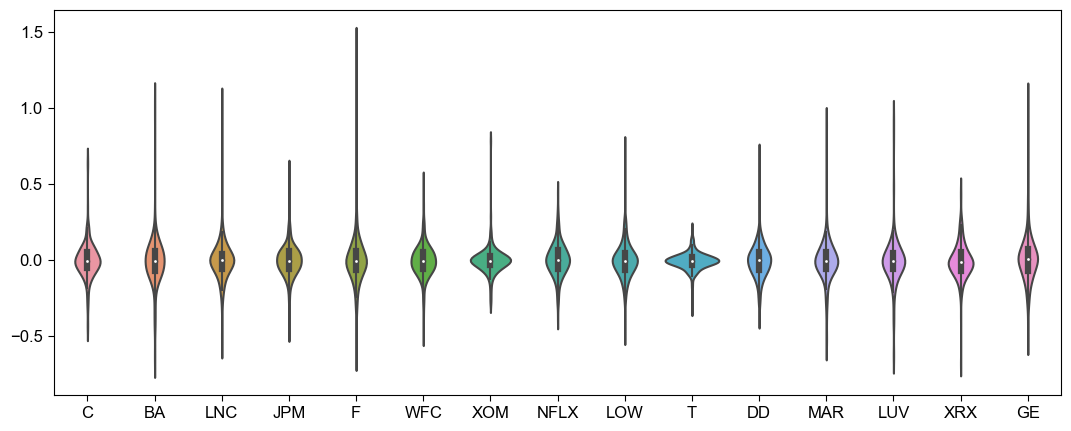

In [234]:
fig, ax = plt.subplots(figsize=(13, 5))
sns.violinplot(data=residuals_boxcar, ax=ax)

A violin plot is a type of data visualization that combines the features of a box plot and a kernel density plot. It is used to represent the distribution of a continuous variable and to compare the distributions between different groups.

Some key points:
1. T interquartile ranges are the smallest.
2. F has the highest interquartile ranges. 
3. T is very wide.
4. XOM is also wide.


1. A low residual value suggests that the regression model has captured much of the variance in the CDS returns and is a good fit for the data. In other words, the model has effectively explained the variation in AT&T's CDS returns, and there is little left to explain through the residual values.

2. If the residuals are low, it means that the regression model is doing a good job of predicting the equity returns for Exxon Mobil, and there is little variation between the predicted and actual values.



### 15. Residual Return and Residual Equity Return Model- (Exponential Regression)

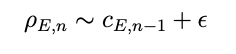

In [227]:
half_life = 12
lma = 2**(-1./half_life)
threshold = 1. / (residual_equity_error_shifted.shape[0]* 500)
w12 = lma**np.arange(residual_equity_error_shifted.shape[0]-1, -1, -1)
exp_1p2_wts = w12[ w12 > threshold]
enough_points = np.where( w12 > 1./20 )[0].shape[0]

In [228]:
def exp_1_2_reg(_df):
    _n = min(exp_1p2_wts.shape[0], _df.shape[0])
    _ldf = _df.iloc[-_n:]
    _wt = exp_1p2_wts[-_n:]
    _p = linreg.WLS(_ldf['y'], _ldf['x'], weights=_wt).fit(params_only=True).params
    return pd.DataFrame(data=[_p], index=[_df.index[-1]])

In [230]:
coefficients_discounted= pd.DataFrame()
for ticker in unique_tickers:
    dataframe_for_regression= pd.DataFrame()
    dataframe_for_regression['y']= (residual_error['p_'+ticker])
    dataframe_for_regression['x']= (residual_equity_error_shifted['c_' + ticker])
    dataframe_for_regression.dropna(inplace= True) 
    exp_1_2_coeffs = pd.concat([exp_1_2_reg(dataframe_for_regression.iloc[max(0,i-exp_1p2_wts.shape[0]):i]) for i in range(enough_points, residual_equity_error_shifted.shape[0])])
    coefficients_discounted[ticker]= exp_1_2_coeffs


In [235]:
coefficients_discounted.head()

C        BA       LNC       JPM         F       WFC  \
2019-04-24  0.000669 -0.009136 -0.000706  0.000663 -0.004506  0.007692   
2019-05-01  0.002260 -0.008728  0.002129  0.004800 -0.005492  0.008348   
2019-05-08  0.003717 -0.006653  0.003527  0.006207 -0.005503  0.009189   
2019-05-15  0.003986 -0.004788  0.005313  0.004337  0.003935  0.008467   
2019-05-22  0.003395 -0.006267  0.006219  0.004283  0.003589  0.007965   

                 XOM      NFLX       LOW         T        DD       MAR  \
2019-04-24 -0.004075 -0.004081 -0.002056 -0.017153  0.020162  0.000151   
2019-05-01 -0.002152 -0.004555  0.003514 -0.016272  0.021166  0.001038   
2019-05-08 -0.000592  0.001069  0.004389 -0.015537  0.024619  0.003631   
2019-05-15 -0.001115  0.002514  0.004255 -0.016814  0.024470  0.007033   
2019-05-22 -0.000270  0.003459  0.008694 -0.017333  0.012157  0.007017   

                 LUV       XRX        GE  
2019-04-24 -0.006279 -0.006860  0.022627  
2019-05-01 -0.004631 -0.003891 -0.001008  
2019-05-08 -0.002326 -0.003342 -0.002197  
2019-05-15 -0.000080 -0.003648 -0.003332  
2019-05-22 -0.000888 -0.003967  0.005881

### 16. Residual Return and Residual Equity Return Model- Analysis (Exponential Regression)

In [237]:
#residuals
residuals_discounted= pd.DataFrame()
predicted_discounted= pd.DataFrame()
for ticker in unique_tickers:
    new_dataframe= pd.DataFrame()
    new_dataframe['u']= coefficients_discounted[ticker]
    new_dataframe['c']= residual_equity_error_shifted['c_'+ticker]
    new_dataframe['p']= residual_error['p_'+ticker]
    new_dataframe['r']= new_dataframe['p']- new_dataframe['c']*new_dataframe['u']
    new_dataframe['predicted']= new_dataframe['c']*new_dataframe['u']
    residuals_discounted[ticker]= new_dataframe['r']
    predicted_discounted[ticker]= new_dataframe['predicted']
residuals_discounted.head()

C        BA       LNC       JPM         F       WFC  \
2019-04-24 -0.068593 -0.060407 -0.073788 -0.051451 -0.057283 -0.043538   
2019-05-01 -0.030889 -0.007558 -0.051490 -0.060409  0.013232 -0.019102   
2019-05-08 -0.028149 -0.049176 -0.028173 -0.017801  0.000257 -0.032545   
2019-05-15 -0.006734 -0.037445 -0.042131  0.024214 -0.180548  0.021209   
2019-05-22  0.013234  0.028725 -0.020734  0.000679  0.006813  0.016330   

                 XOM      NFLX       LOW         T        DD       MAR  \
2019-04-24  0.007202  0.023012 -0.059588 -0.036875 -0.048614 -0.039048   
2019-05-01 -0.029327  0.014240 -0.076708 -0.010645 -0.030862 -0.012213   
2019-05-08 -0.024481 -0.288627 -0.013922 -0.018335 -0.095661 -0.029630   
2019-05-15  0.007156 -0.084725  0.001647  0.027459  0.001682 -0.038813   
2019-05-22 -0.012103 -0.042821 -0.057797  0.032758  0.151302  0.000194   

                 LUV       XRX        GE  
2019-04-24 -0.031462 -0.085452  0.000479  
2019-05-01 -0.019659 -0.083277  0.174664  
2019-05-08 -0.030430 -0.015454  0.010205  
2019-05-15 -0.027711  0.009559  0.014107  
2019-05-22  0.011143  0.010611 -0.126256

In [239]:
#r2score
r2_score_dic={}
for ticker in unique_tickers:
    r2_score_dic[ticker]= r2_score(residual_error['p_'+ticker][54:], predicted_discounted[ticker][4:])
r2_df = pd.DataFrame(r2_score_dic, index= ['R2_SCORE'])
display(r2_df.T)

R2_SCORE
C     0.092427
BA    0.204561
LNC   0.099467
JPM   0.072277
F     0.116388
WFC   0.114921
XOM   0.088936
NFLX  0.086303
LOW   0.077937
T     0.039240
DD    0.059148
MAR   0.156583
LUV   0.123293
XRX   0.045379
GE    0.067295

<AxesSubplot: >

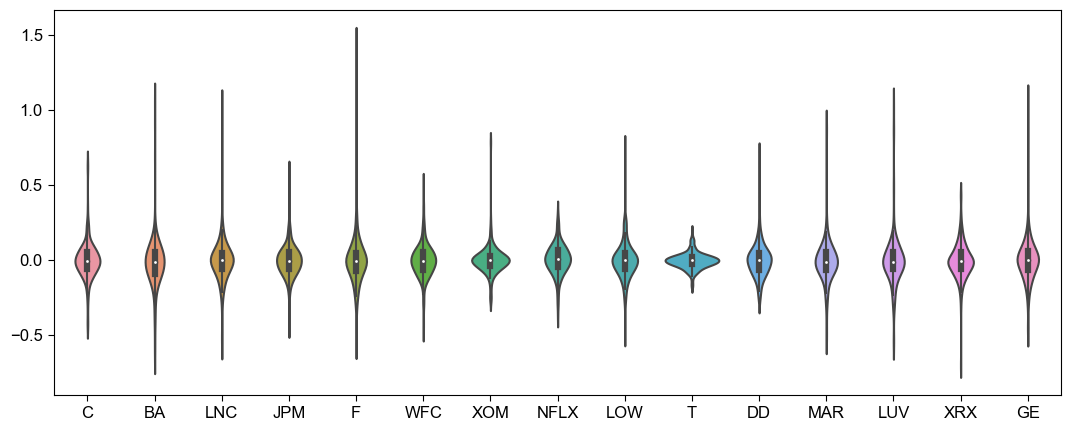

In [240]:
fig, ax = plt.subplots(figsize=(13, 5))
sns.violinplot(data=residuals_discounted, ax=ax)

The above r2 score and the violin plots are in agreement with the above explanations for the boxcar case

### 17. Compare performance of predictive regressions in exponentially decaying (i.e. discounted) versus boxcar forms.

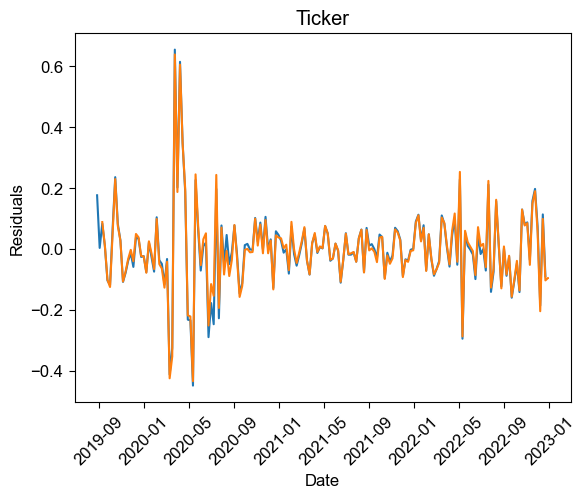

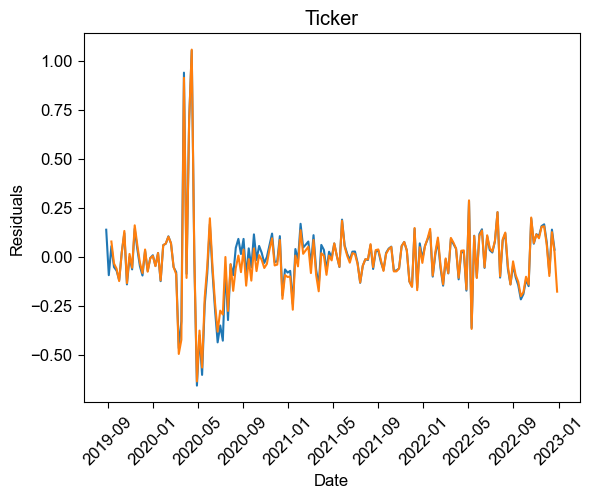

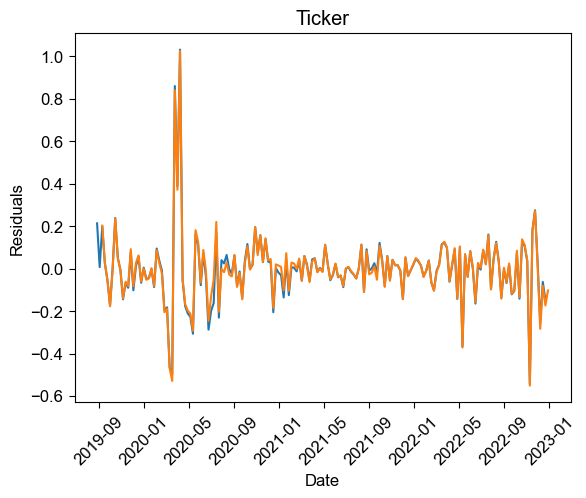

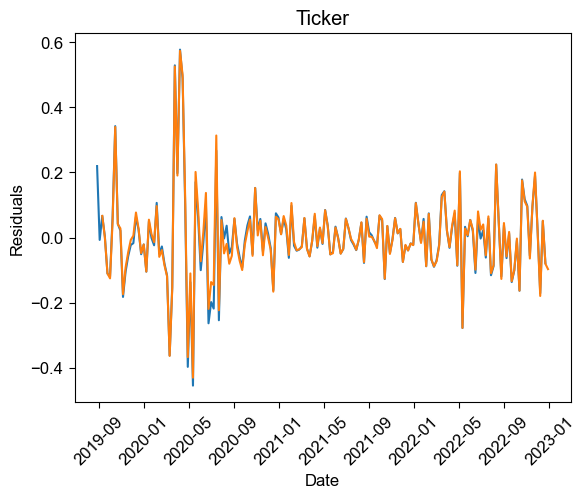

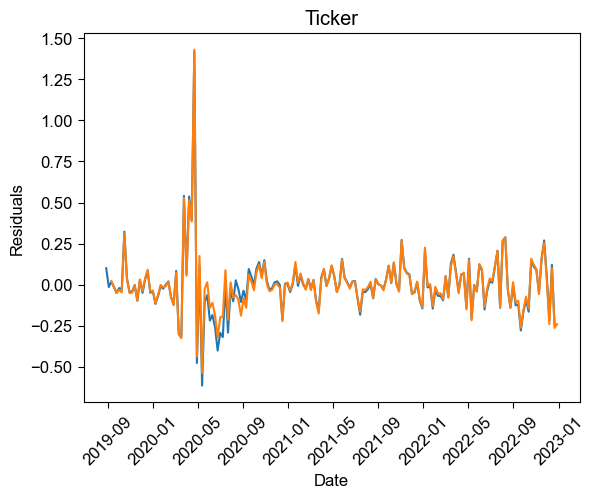

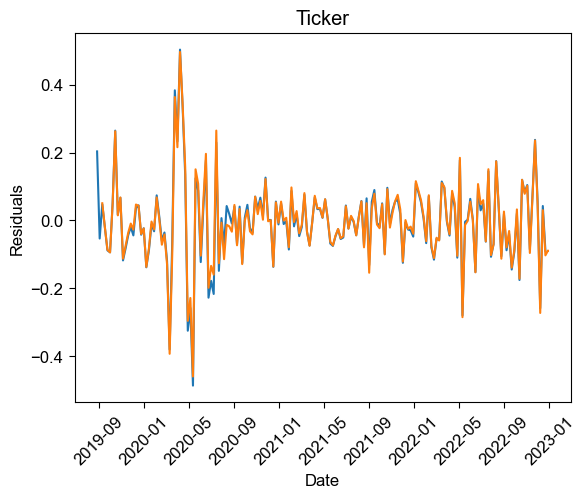

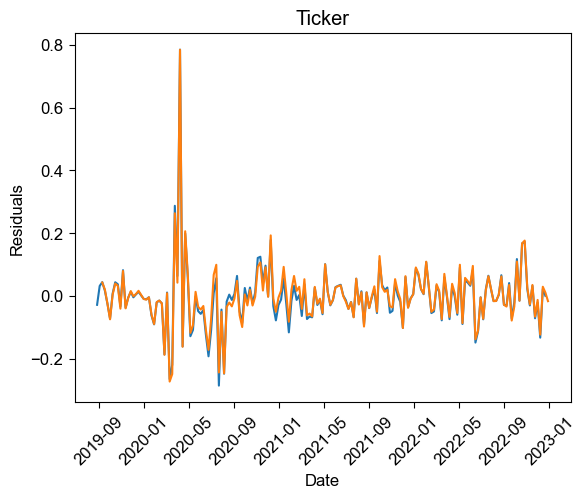

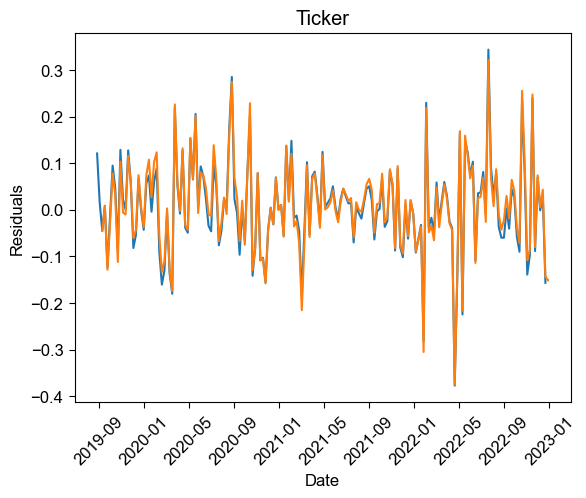

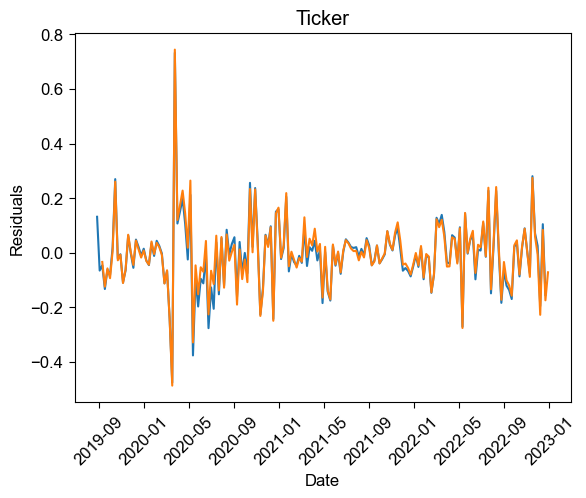

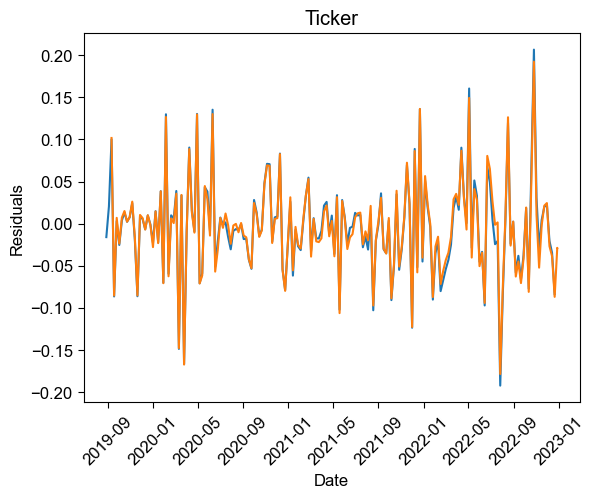

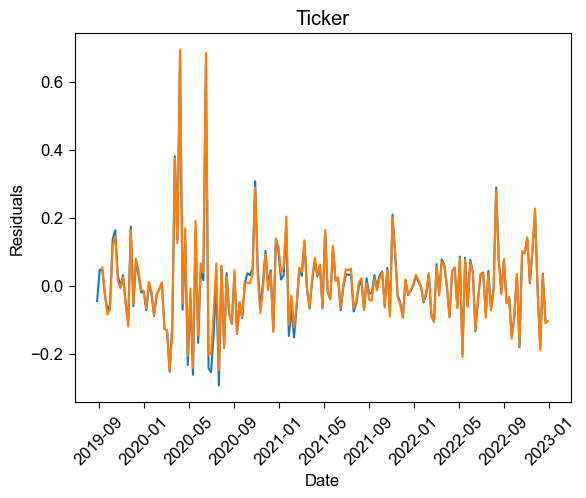

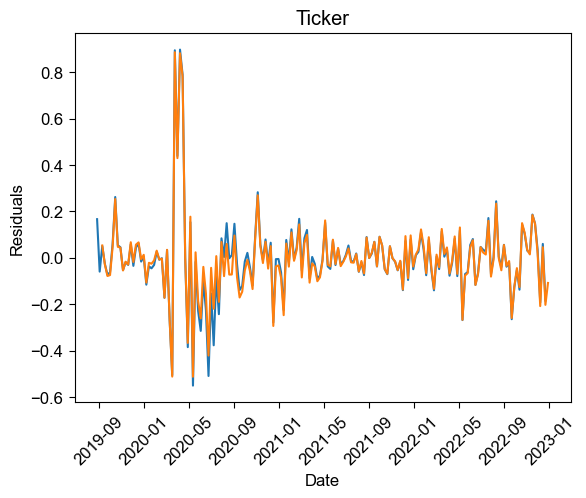

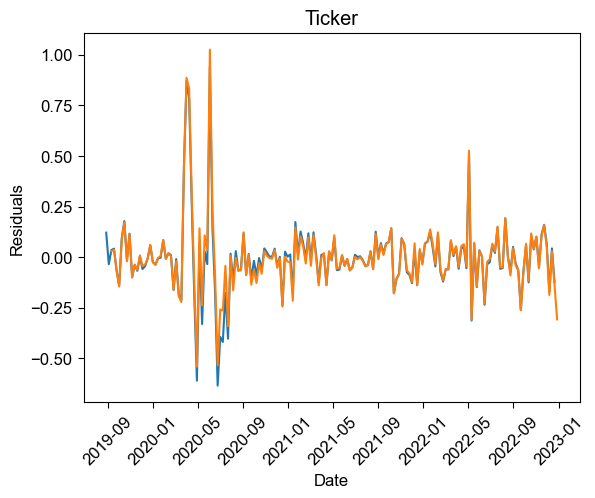

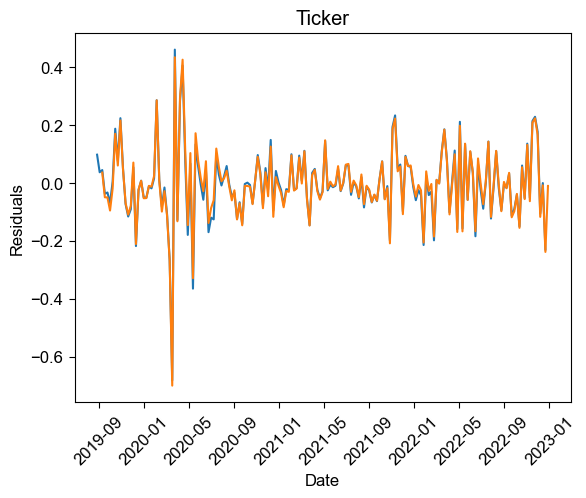

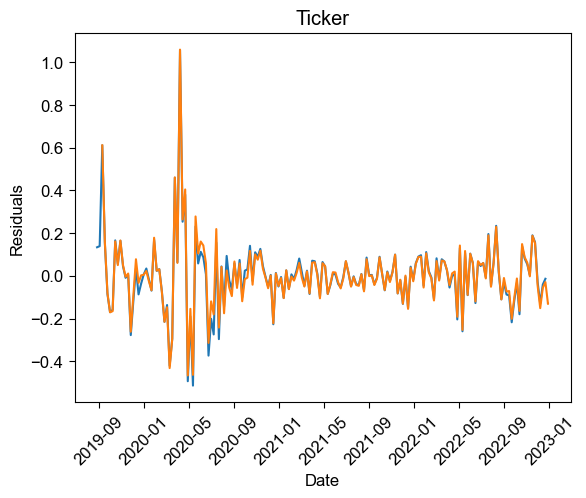

In [304]:
for ticker in unique_tickers:
    plt.plot(residuals_boxcar[54:][ticker])
    plt.plot(residuals_discounted[20:][ticker])
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.title('Ticker')
    plt.xticks(rotation= 45)
    plt.show()


Here we see that the boxcar and the expoenntially tme decay regression algorithms have very similar residuals. The similarity in residuals between these two methods could be due to several factors. One possible reason is that both methods use historical data to smooth out the noise in the time series and generate a trend line. In other words, they are both capturing the underlying pattern in the data and removing the random noise, leading to similar residuals.

Another possible reason is that the two methods might be overfitting the data, meaning they are capturing the noise in the data and not just the underlying trend. This could lead to similar residuals even though the methods are fundamentally different.

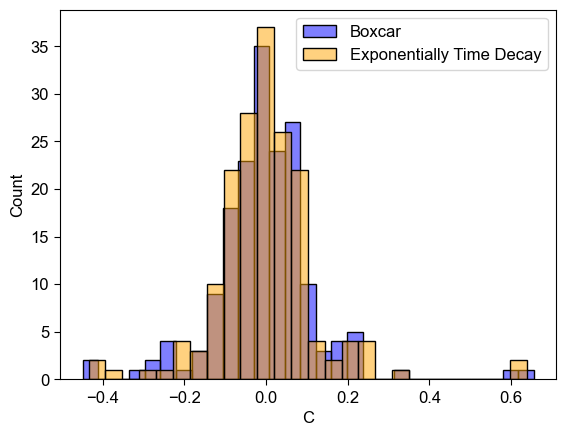

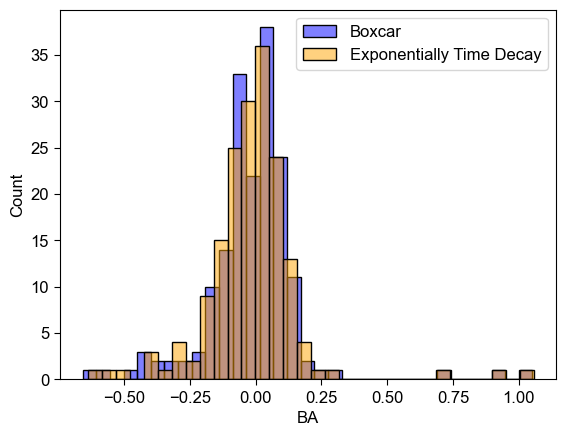

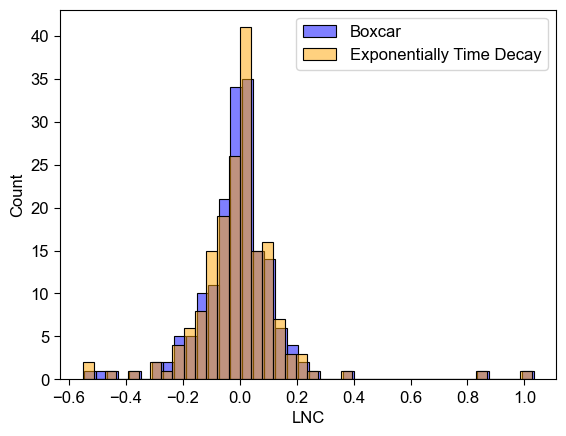

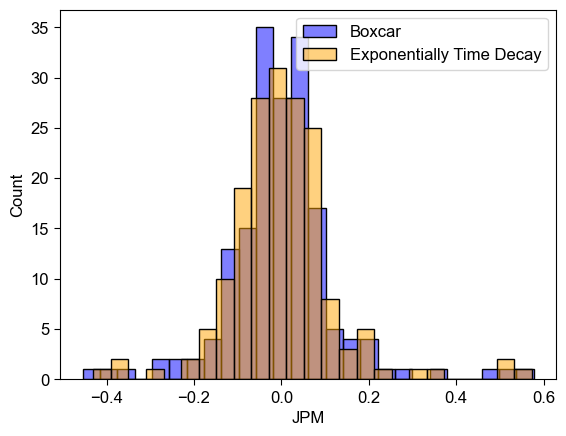

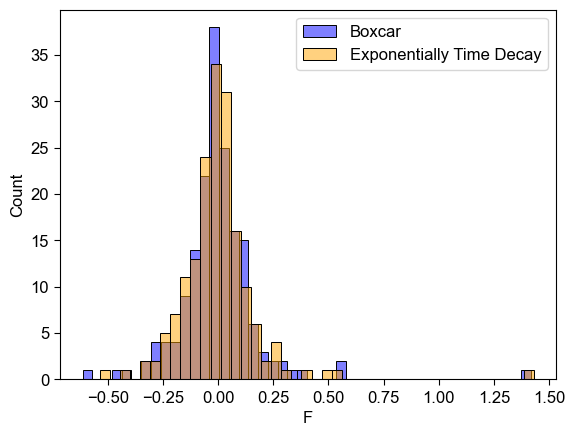

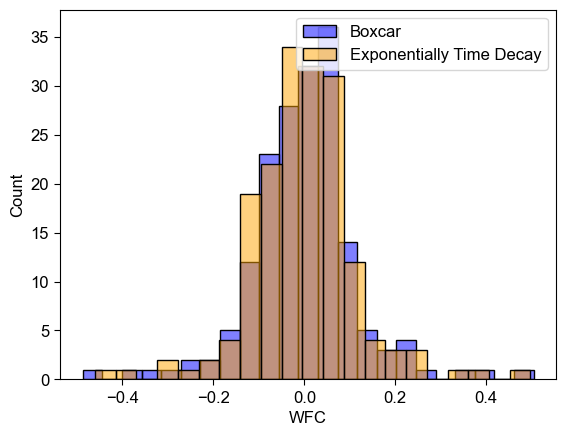

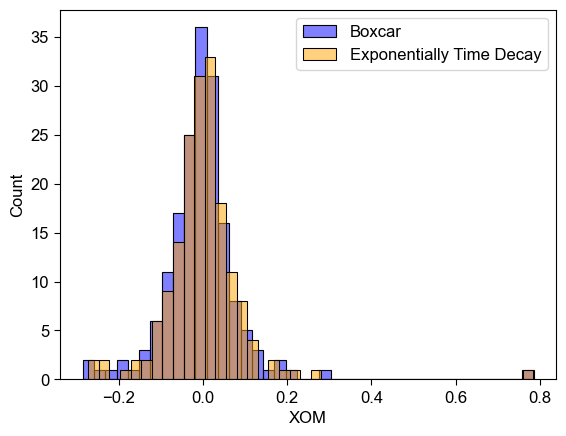

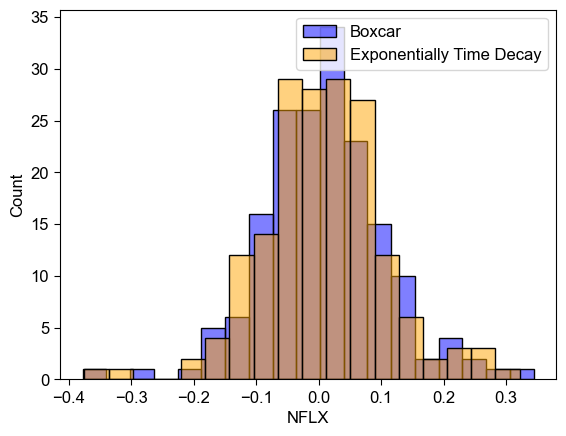

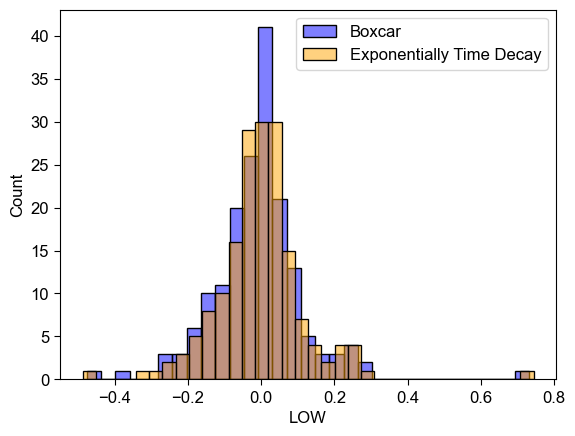

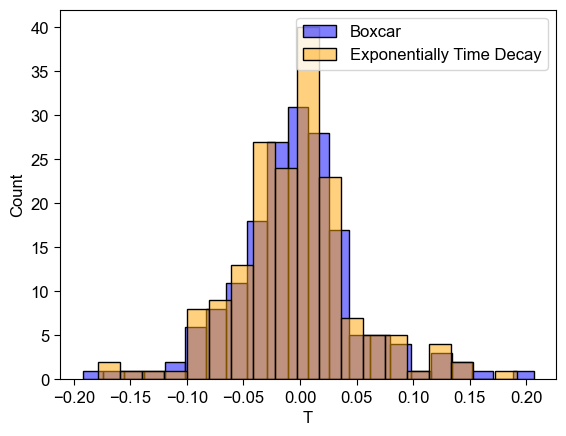

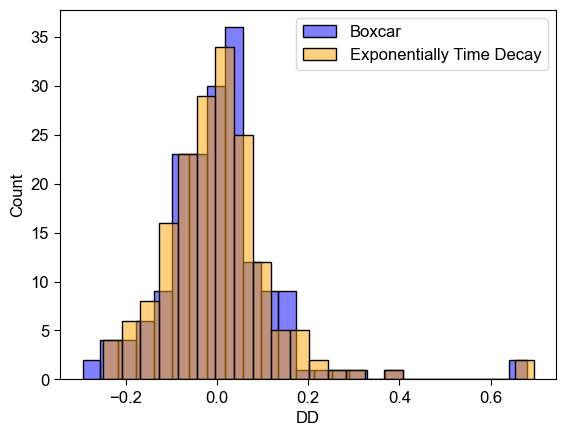

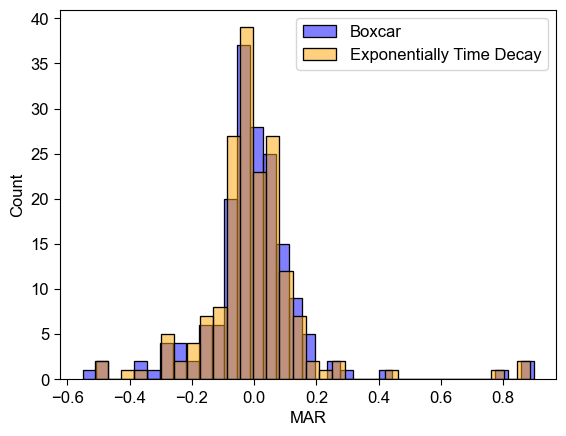

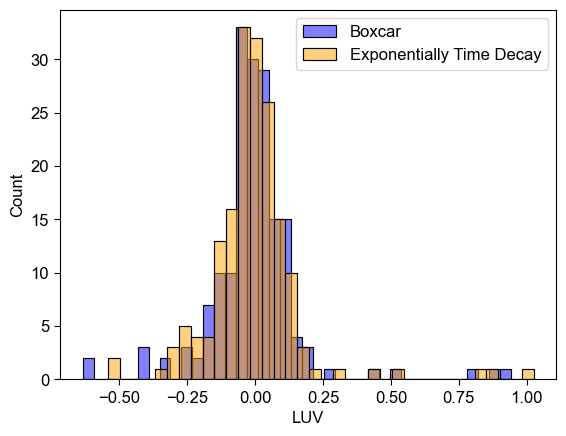

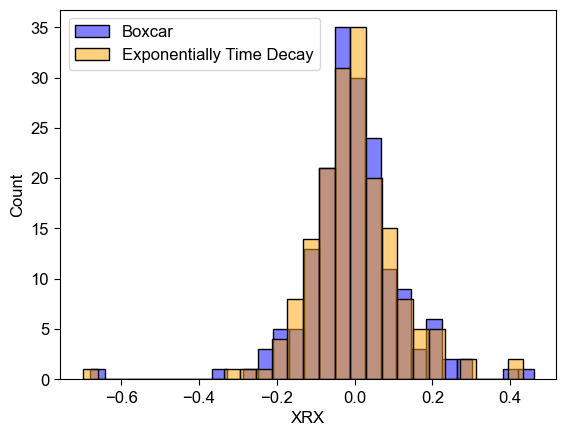

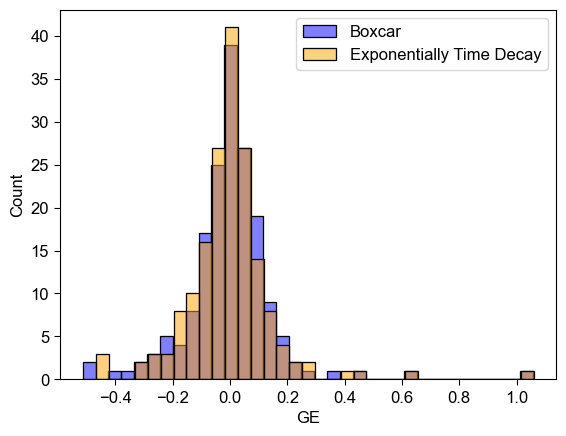

In [305]:
for ticker in unique_tickers:
    sns.histplot(residuals_boxcar[54:][ticker], color='blue', alpha=0.5, label='Boxcar')
    sns.histplot(residuals_discounted[20:][ticker], color= 'orange', alpha=0.5, label='Exponentially Time Decay')
    plt.legend()
    plt.show()

Again here the histoplots are very similar. They have outliers and a very slight skew in some cases. This reinforces the notion that outliers should be idetnified and appropriately dealt with.

### 18.  Historical Events and their Impact

CDS, or Credit Default Swaps, are a type of financial instrument that allows investors to protect themselves against the risk of a borrower defaulting on their debt. The prices of CDS are influenced by a wide range of economic, financial, and geopolitical events. Here are a few events that have occurred between 2018 and 2022 that may have affected the prices of CDS:

The COVID-19 Pandemic: The outbreak of the COVID-19 pandemic in early 2020 had a significant impact on the global economy and financial markets, including the prices of CDS. As the pandemic spread and caused widespread disruptions to businesses and supply chains, many investors became concerned about the potential for borrowers to default on their debts. This led to an increase in the prices of CDS for many companies and governments.

US-China Trade War: In 2018, the United States and China began imposing tariffs on each other's goods as part of a trade war. The trade tensions between the two countries had a significant impact on global trade and economic growth, which in turn affected the prices of CDS. Investors became increasingly concerned about the potential for companies and governments to default on their debts as a result of the trade tensions, which led to an increase in the prices of CDS.

Political Turmoil: Political instability and uncertainty can have a significant impact on the prices of CDS, as investors become concerned about the potential for governments to default on their debts. Between 2018 and 2022, there were several instances of political turmoil that may have affected the prices of CDS, including Brexit negotiations, the impeachment of former US President Donald Trump, and the 2021 coup in Myanmar.

Central Bank Policy: The policies of central banks, such as the US Federal Reserve and the European Central Bank, can also have a significant impact on the prices of CDS. In recent years, central banks have implemented a range of monetary policy measures to support economic growth and stability, including cutting interest rates and purchasing government bonds. These policies can affect the prices of CDS by influencing the overall level of economic and financial risk in the market.

The covid pandemic led the regression to sometimes give very high errors or residuals because the model wwant; prepraed for the abrupt changes. All of these events add volatility and hence the model is not able to accuracetly predict it.

### 19. Tails and Other statistics

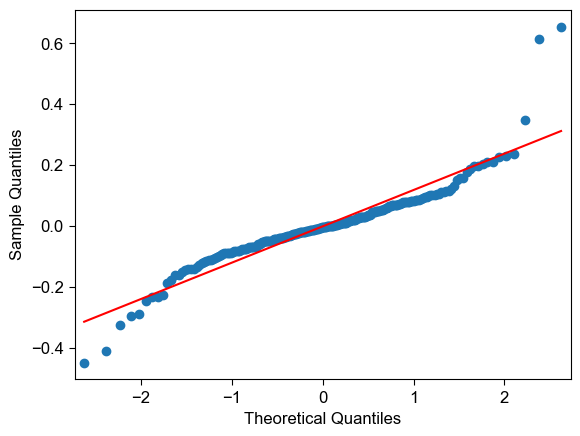

Residual mean: -0.001545038822237187
Residual standard deviation: 0.11947161441120953
Residual t-statistic: 0.0
Residual p-value: 1.0


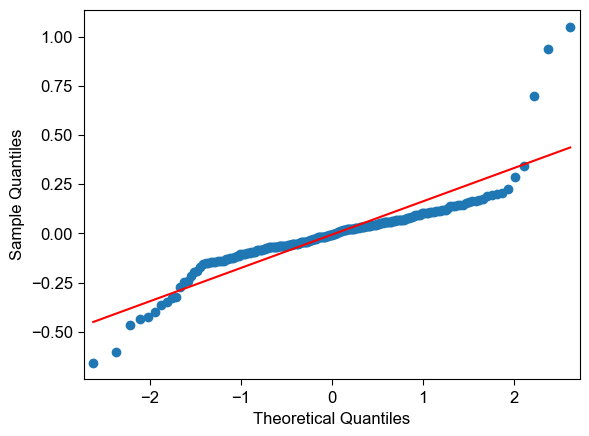

Residual mean: -0.006781408539135381
Residual standard deviation: 0.16911306453705954
Residual t-statistic: 0.0
Residual p-value: 1.0


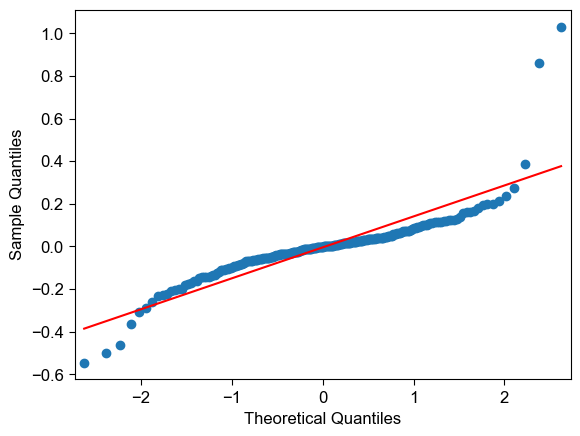

Residual mean: -0.004539138180548747
Residual standard deviation: 0.1454454570269807
Residual t-statistic: 0.0
Residual p-value: 1.0


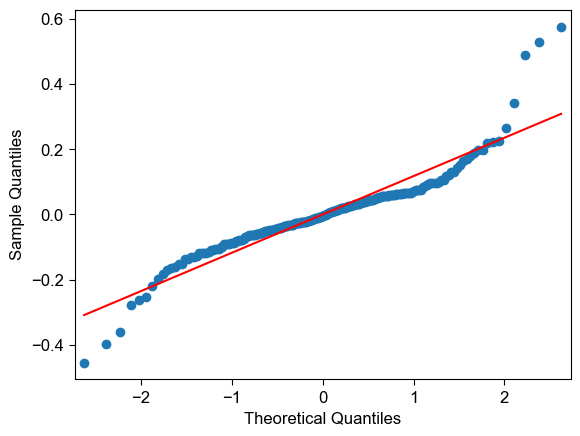

Residual mean: 1.313572120704938e-05
Residual standard deviation: 0.11776467155658676
Residual t-statistic: 0.0
Residual p-value: 1.0


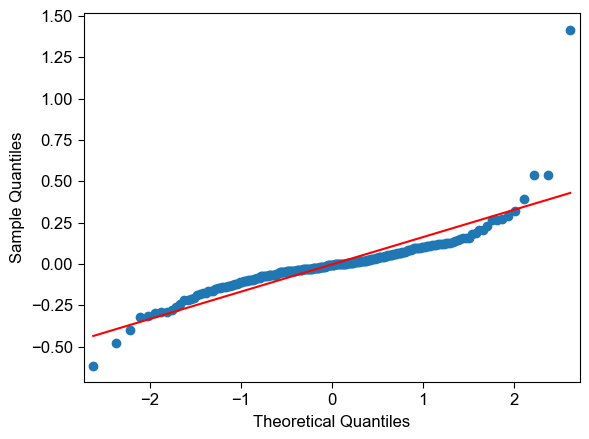

Residual mean: -0.002540938596537585
Residual standard deviation: 0.16487939677649224
Residual t-statistic: 0.0
Residual p-value: 1.0


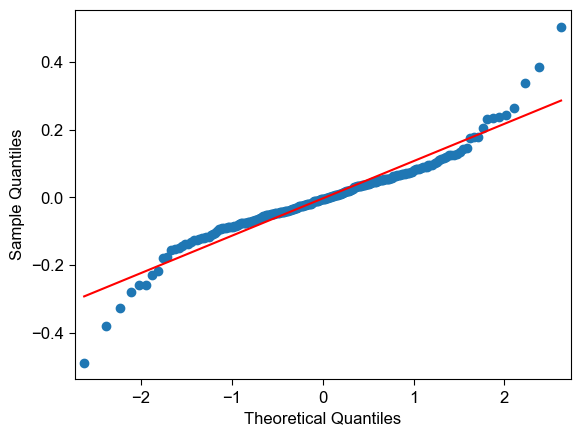

Residual mean: -0.0031565779788119935
Residual standard deviation: 0.1101691018012163
Residual t-statistic: 0.0
Residual p-value: 1.0


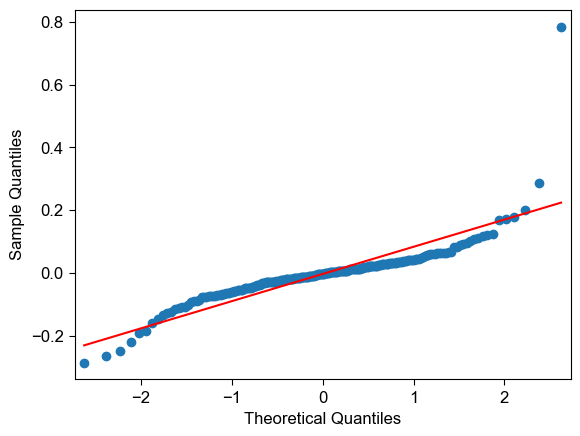

Residual mean: -0.00349492062606059
Residual standard deviation: 0.08670682250987786
Residual t-statistic: 0.0
Residual p-value: 1.0


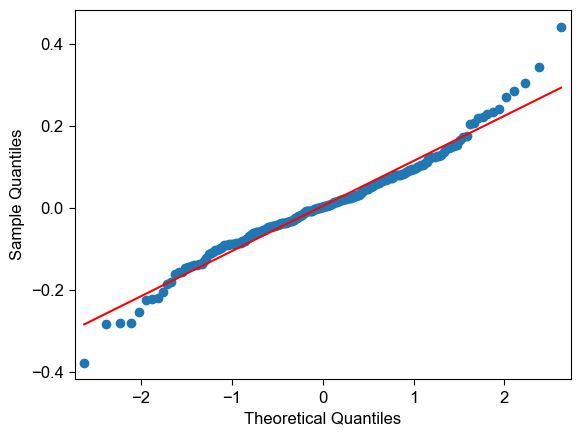

Residual mean: 0.004342317023203081
Residual standard deviation: 0.11009287327584306
Residual t-statistic: 0.0
Residual p-value: 1.0


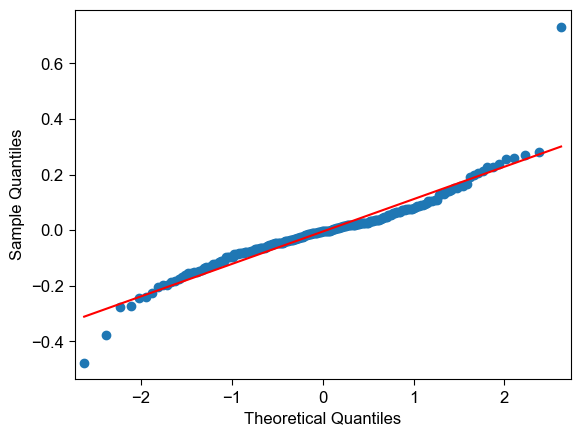

Residual mean: -0.005043760992128868
Residual standard deviation: 0.11667162271968132
Residual t-statistic: 0.0
Residual p-value: 1.0


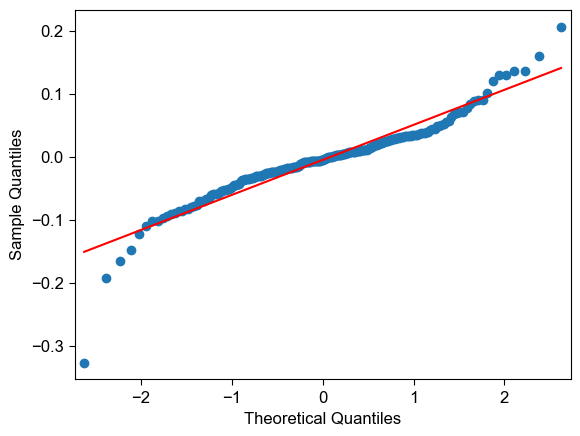

Residual mean: -0.00530571746839901
Residual standard deviation: 0.05566027914153895
Residual t-statistic: 0.0
Residual p-value: 1.0


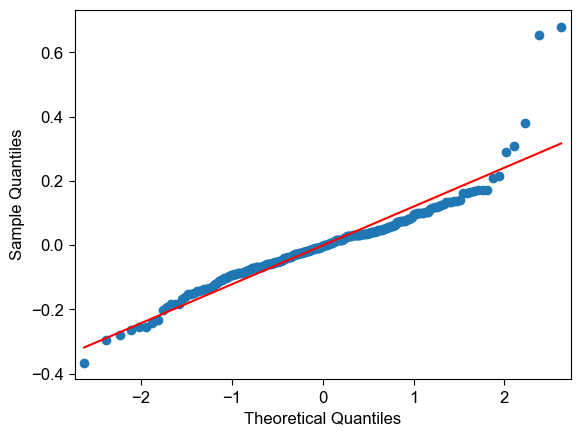

Residual mean: -0.0008525592099170514
Residual standard deviation: 0.12104753721017246
Residual t-statistic: 0.0
Residual p-value: 1.0


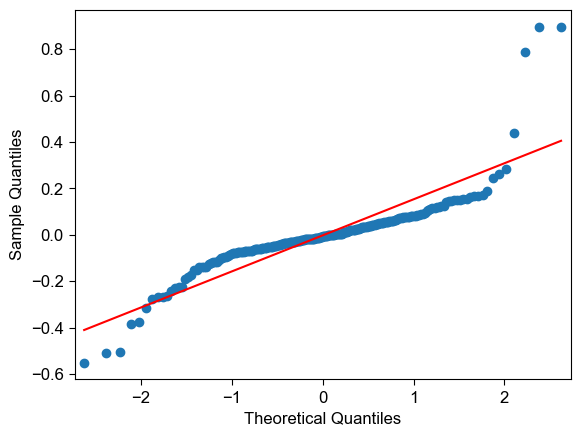

Residual mean: -0.002754433304486087
Residual standard deviation: 0.15549085748302105
Residual t-statistic: 0.0
Residual p-value: 1.0


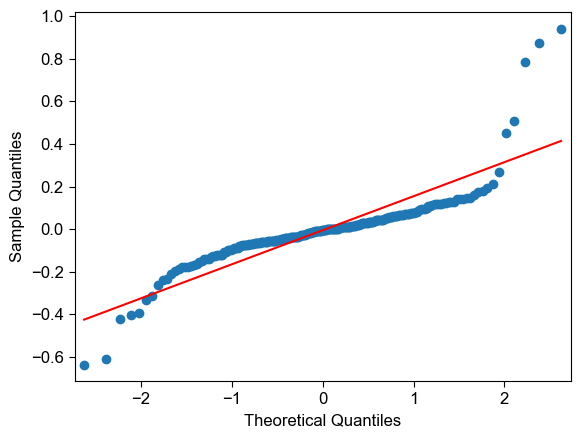

Residual mean: -0.005140180976862541
Residual standard deviation: 0.15979363185519357
Residual t-statistic: 0.0
Residual p-value: 1.0


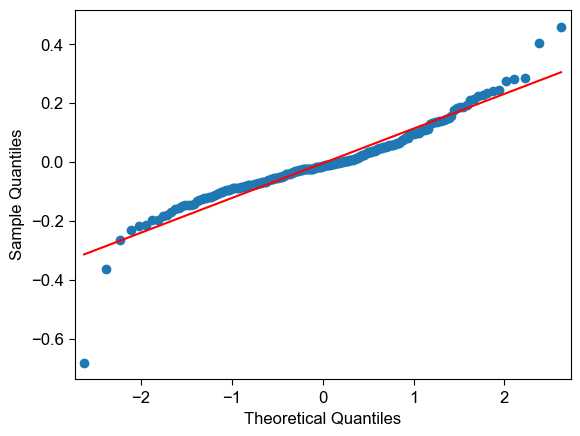

Residual mean: -0.004395646409717224
Residual standard deviation: 0.11798478006558999
Residual t-statistic: 0.0
Residual p-value: 1.0


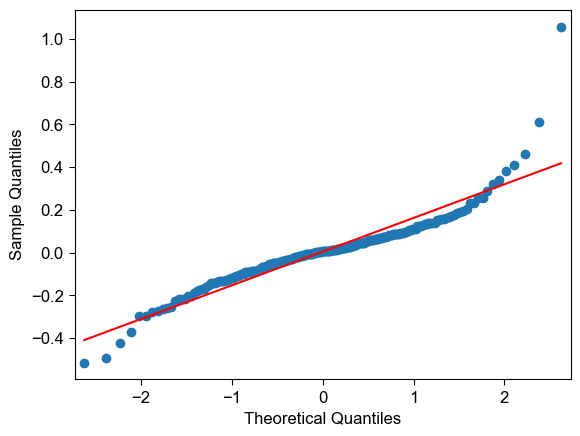

Residual mean: 0.00445318747341338
Residual standard deviation: 0.15772111194663874
Residual t-statistic: 0.0
Residual p-value: 1.0


In [306]:
for ticker in unique_tickers:
    smg.ProbPlot(residuals_boxcar[ticker]).qqplot(line='s')
    plt.show()
    resid_mean = np.mean(residuals_boxcar[ticker])
    resid_std = np.std(residuals_boxcar[ticker])
    resid_tstat, resid_pval = ttest_1samp(residuals_boxcar[ticker], resid_mean)

    print("Residual mean:", resid_mean)
    print("Residual standard deviation:", resid_std)
    print("Residual t-statistic:", resid_tstat)
    print("Residual p-value:", resid_pval)

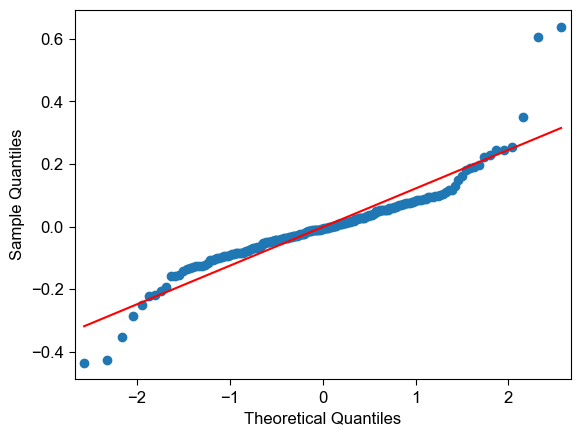

Residual mean: -0.0017990115204357367
Residual standard deviation: 0.12336329049907108
Residual t-statistic: 0.0
Residual p-value: 1.0


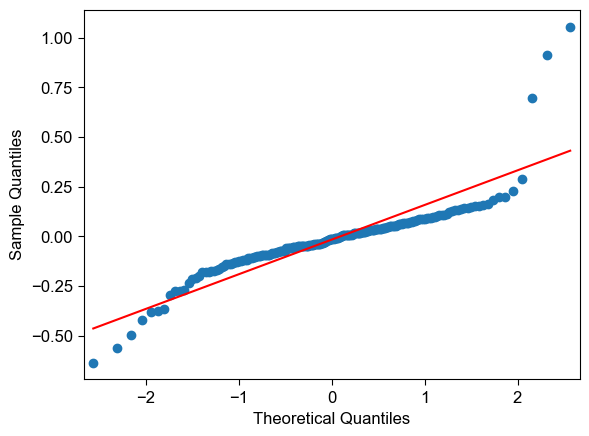

Residual mean: -0.016233034244206433
Residual standard deviation: 0.1742822573252547
Residual t-statistic: 0.0
Residual p-value: 1.0


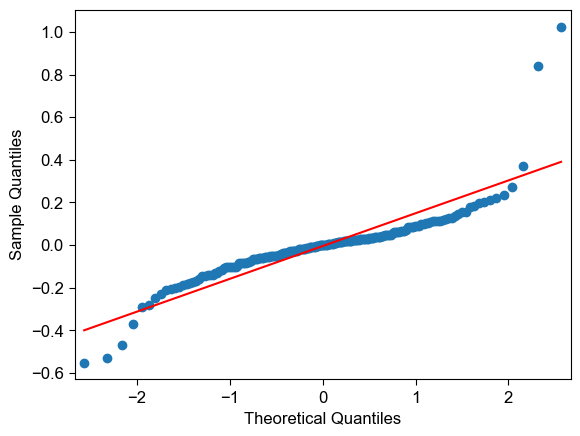

Residual mean: -0.00477209000721612
Residual standard deviation: 0.15395121316508292
Residual t-statistic: 0.0
Residual p-value: 1.0


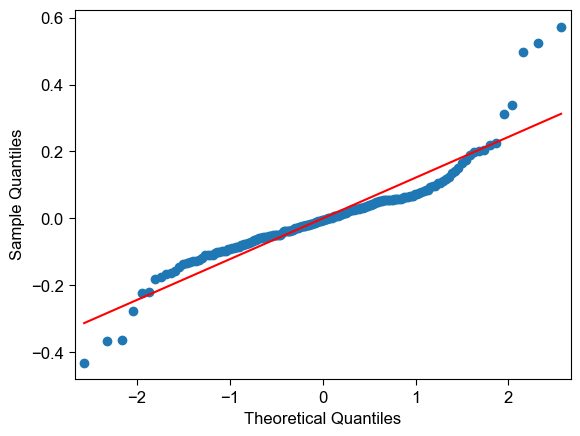

Residual mean: 7.170492523572864e-05
Residual standard deviation: 0.12169958007162904
Residual t-statistic: 0.0
Residual p-value: 1.0


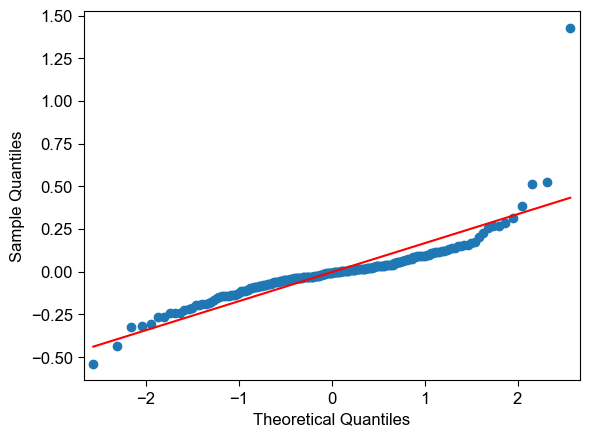

Residual mean: -0.002608322349389109
Residual standard deviation: 0.16979282836184134
Residual t-statistic: 0.0
Residual p-value: 1.0


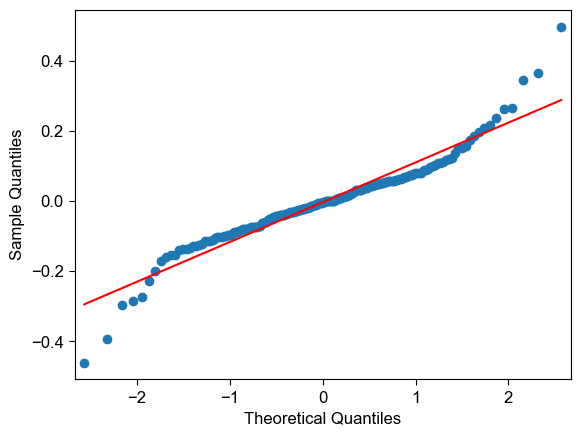

Residual mean: -0.003440518953156248
Residual standard deviation: 0.1133821025966209
Residual t-statistic: 0.0
Residual p-value: 1.0


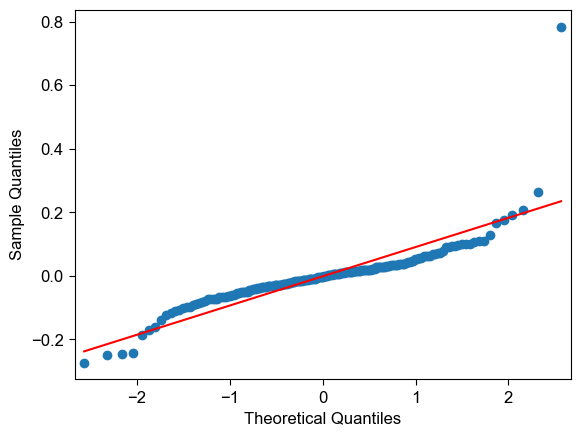

Residual mean: -0.0013751734869451822
Residual standard deviation: 0.09201071928168401
Residual t-statistic: 0.0
Residual p-value: 1.0


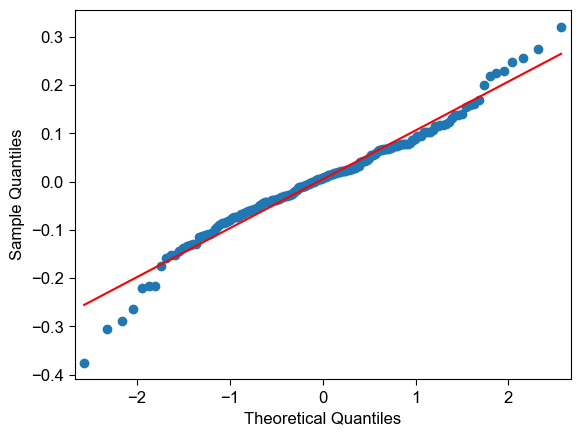

Residual mean: 0.004897596455278823
Residual standard deviation: 0.10133907599121877
Residual t-statistic: 0.0
Residual p-value: 1.0


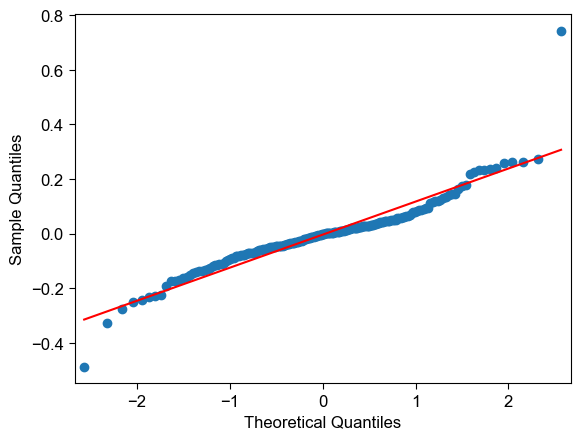

Residual mean: -0.00387663524988888
Residual standard deviation: 0.12115869244827444
Residual t-statistic: 0.0
Residual p-value: 1.0


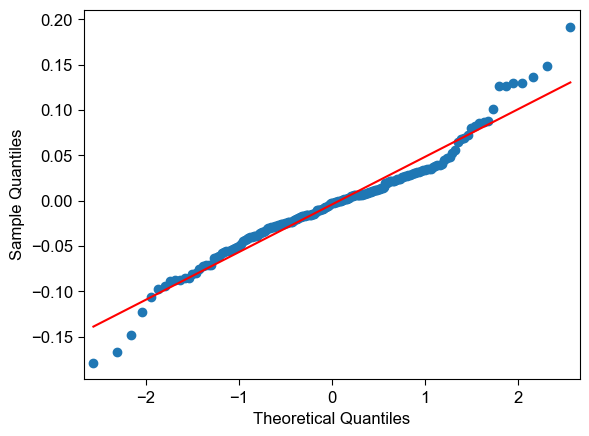

Residual mean: -0.004115653255044959
Residual standard deviation: 0.052428949507608784
Residual t-statistic: 0.0
Residual p-value: 1.0


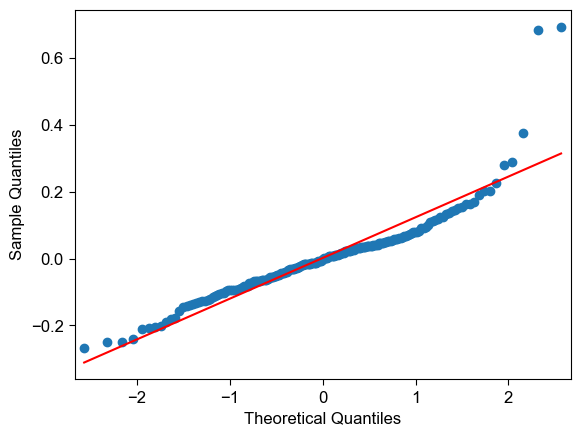

Residual mean: 0.0015079422144507147
Residual standard deviation: 0.12187846674184466
Residual t-statistic: 0.0
Residual p-value: 1.0


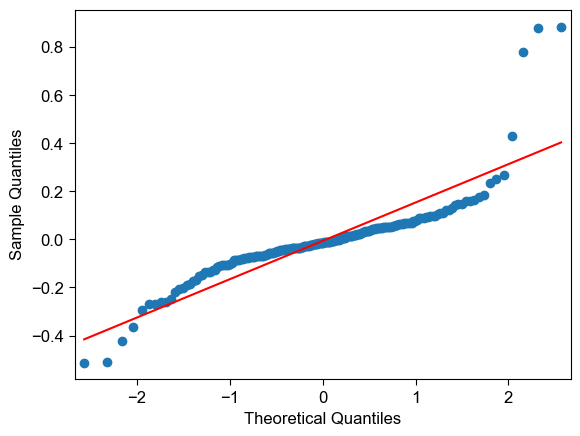

Residual mean: -0.006007744246916647
Residual standard deviation: 0.15963333228488483
Residual t-statistic: 0.0
Residual p-value: 1.0


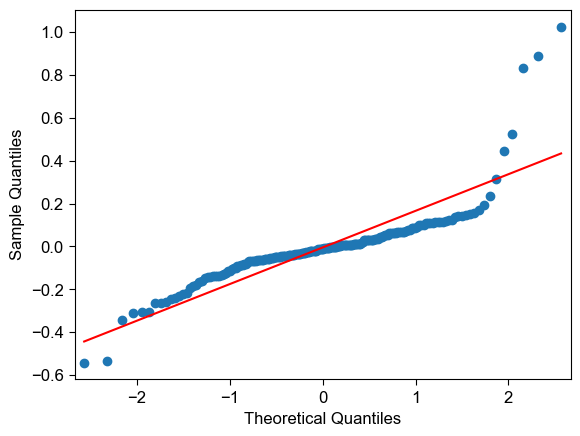

Residual mean: -0.004730308801999526
Residual standard deviation: 0.17082828300251343
Residual t-statistic: 0.0
Residual p-value: 1.0


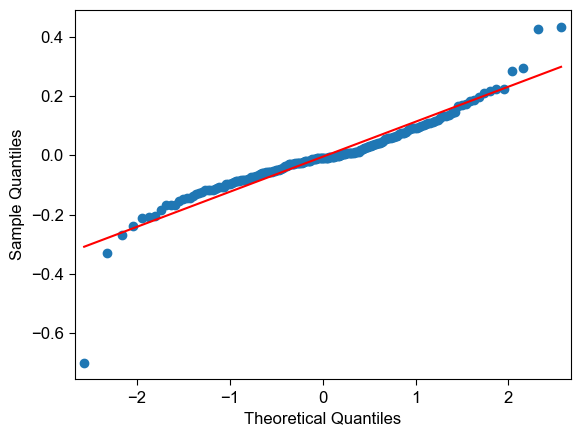

Residual mean: -0.005301620477709675
Residual standard deviation: 0.1181564050335169
Residual t-statistic: 0.0
Residual p-value: 1.0


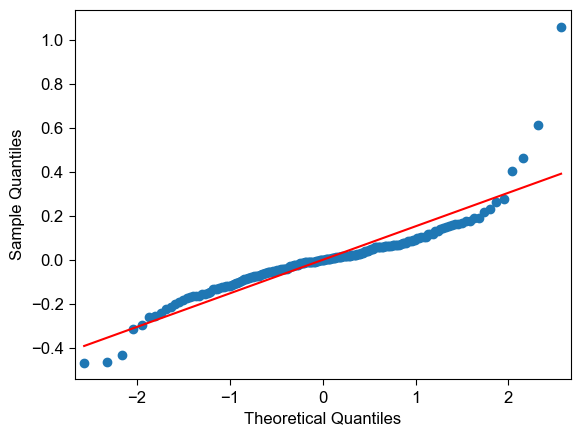

Residual mean: -0.00019483900113388585
Residual standard deviation: 0.15236206379293613
Residual t-statistic: 0.0
Residual p-value: 1.0


In [307]:
for ticker in unique_tickers:
    smg.ProbPlot(residuals_discounted[ticker]).qqplot(line='s')
    plt.show()
    resid_mean = np.mean(residuals_discounted[ticker])
    resid_std = np.std(residuals_discounted[ticker])
    resid_tstat, resid_pval = ttest_1samp(residuals_discounted[ticker], resid_mean)

    print("Residual mean:", resid_mean)
    print("Residual standard deviation:", resid_std)
    print("Residual t-statistic:", resid_tstat)
    print("Residual p-value:", resid_pval)

### 20. Creation of a trading strategy

In [343]:
def trading_strategy(ticker):
    
    df= etf_df_dic[ticker]
    capital= 1 #just a simple case where we have 1 dollar
    pnl=[]
    pred= list(rcds_prediction[ticker][:240])
    actual= list(etf_df_dic[ticker]['returns_cds'][:240])
    position=0
    
    #-1 means short and +1 means long
    for i in range(0, len(actual)):
        if pred[i]<0.1 and pred[i] >-0.1:
            pass # do nothing case
        if pred[i] >=0.1:
            position=1
        else:
            position=-1
        pl= position*actual[i]
        pnl.append(pl)
        price_of_equity= df['returns_cds']
        
    plt.plot(etf_df_dic[ticker][:240].index, pnl)
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.show()
    
    pnl_series= pd.Series(pnl)
    cum_pnl= pnl_series.cumsum()
    plt.plot(etf_df_dic[ticker][:240].index, cum_pnl)
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')
    plt.show()
    
    

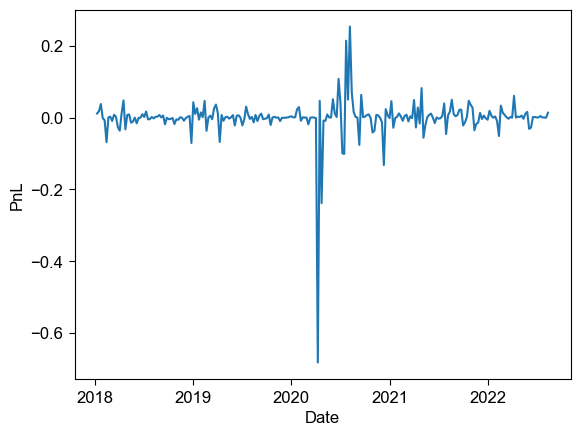

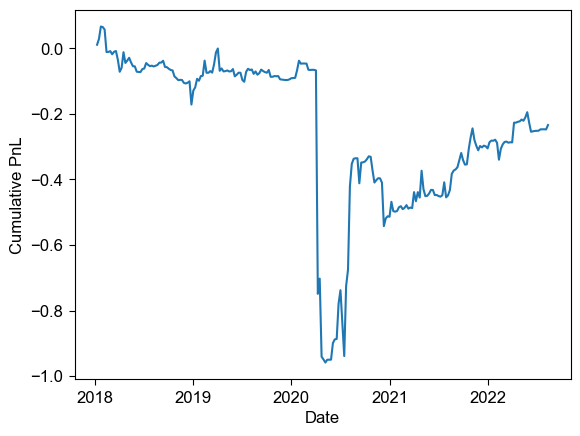

In [345]:
#example of a trading strategy
trading_strategy('')

This is just a very simple trading strategy. to create a more comprehensive trading strategy one must consider.

a. Transcation costs

b. the do nothing parameters

c. Other economic factors

d. how much can short or long

e. Assumption of the prices of the equities are unchanging

### 21. ARMA Model

In [364]:
for ticker in unique_tickers:
    dataframe_for_regression= pd.DataFrame()
    dataframe_for_regression['y']= (residual_error['p_'+ticker])
    dataframe_for_regression.dropna(inplace= True)
    model = sm.tsa.AutoReg(dataframe_for_regression, lags= [1, 2]).fit()
    pred= model.predict(start= dataframe_for_regression['y'].index[0], end=dataframe_for_regression['y'].index[-1])
    r2_ticker= r2_score(pred[2:], dataframe_for_regression['y'][2:])
    print(ticker+": " + str(r2_ticker))


C: -64.68391257413224
BA: -15.680714031630878
LNC: -56.83204413097715
JPM: -66.06537329595038
F: -12.223131880521123
WFC: -50.387773727143475
XOM: -18.509018559954995
NFLX: -155.7678264459615
LOW: -218.2578647258351
T: -100.82440811638892
DD: -62.08850296391626
MAR: -9.298495608489313
LUV: -9.292304000064028
XRX: -64.11560725279153
GE: -31.266955000907494


ARMA stands for Autoregressive Moving Average. It is a type of time series model that combines both autoregression (AR) and moving average (MA) components.

#### This above demonstrates that the arma model does not do too well ascompared to boxcar

ARMA models can be useful for modeling stationary time series data that exhibit some degree of autocorrelation. However, ARMA models can have limitations and may not perform well in certain situations.

One limitation of ARMA models is that they assume that the underlying data is stationary, which means that the statistical properties of the data do not change over time. If the data is non-stationary, such as in the case of a trending or seasonal time series, then an ARMA model may not be appropriate.

Another limitation of ARMA models is that they can be difficult to estimate if the order of the model is not well-chosen. Choosing the appropriate values of p and q (the orders of the AR and MA components, respectively) can be challenging, and using the wrong values can result in a poor model fit.

### 22. Regression Test Train

Instead of using a rolling window, a test train regression can also be used.

However, after some literature review it was clear that the rollwing window was abetter option as compared to splitting the data into test and traing regression.

Rolling window analysis and test/train split are both techniques that can be used to evaluate the performance of a regression model. However, rolling window analysis has some advantages over test/train split, depending on the specific problem being addressed.

The main advantage of rolling window analysis is that it allows you to evaluate the performance of the model over time, using the most recent data. This is particularly useful for time series data, where the relationship between the predictor variables and the response variable may change over time. With rolling window analysis, you can see how well your model performs as the underlying relationships between the variables change.

On the other hand, test/train split is useful when you want to evaluate the performance of a model on a single point in time, and don't care about how it performs over time. This can be useful for cross-sectional data, where the relationships between the variables are assumed to be constant over time.

In some cases, you may use both techniques together. For example, you could use rolling window analysis to evaluate the performance of your model over time, and test/train split to evaluate its performance on a specific period of time that you're interested in. Ultimately, the choice of which technique to use depends on the specific problem you're trying to solve and the nature of your data.


### 23. Conclusion

This project allowed us to see the different predictive regressive methods in the context of cds spreads. It also opened up the avenue that it  this analysis can be used for a trading strategy. However, to make the regression better there could be other improvement and future work which could be done.

#### Modifications or analysis of regression method
1. Outliers as seen from the box plot should be handled
2. Tuning the parameters of K and half-life
3. cross validation
4. ensemble methods